In [1]:
# Tratamiento de datos
import pandas as pd
import numpy as np

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Procesado y modelado
from sklearn.model_selection import train_test_split, RepeatedKFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import r2_score, mean_squared_error


In [2]:
# configuración de matplotlib
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.dpi"] = 200
# plt.style.use("bmh")
sns.set_style("darkgrid")

palette = ["#f6114a", "#0aa0bf", "#f36e98", 
           "#78b177", "#9862a2", "#f05006", 
           "#25998f", "#fca00c"]

# Datos

* **Description**: Una breve descripción sobre la vivienda
* **Price**: El precio de la vivienda
* **Zip_code**: El código postal de la vivienda
* **Bedrooms**: El número de recámaras de la vivienda
* **bathrooms**: Número de baños con los que cuenta la vivienda
* **Built_area**: Cantidad de metros cuadrados construidos de la vivienda
* **Land_area**: Cantidad de metros cuadrados del terreno de la vivienda
* **Parking**: Número de lugares de estacionamiento con los que cuenta la vivienda

In [3]:
# Se cargan los dataframes con los datos limpios
arlette = pd.read_csv("/home/mario/Proyectos_Mario/proyecto_alonso/datos_limpios/datos_arlette.csv")
lamudi = pd.read_csv("/home/mario/Proyectos_Mario/proyecto_alonso/datos_limpios/datos_lamudi.csv")
mercadoLibre = pd.read_csv("/home/mario/Proyectos_Mario/proyecto_alonso/datos_limpios/datos_mercadoLibre.csv")
mitula = pd.read_csv("/home/mario/Proyectos_Mario/proyecto_alonso/datos_limpios/datos_mitula.csv")
nocnok = pd.read_csv("/home/mario/Proyectos_Mario/proyecto_alonso/datos_limpios/datos_nocnok.csv")
nuroa = pd.read_csv("/home/mario/Proyectos_Mario/proyecto_alonso/datos_limpios/datos_nuroa.csv")

In [4]:
orden_columnas = ["description", "price", "zip_code", "bedrooms", 
                  "bathrooms", "built_area", "land_area", "parking"]

# Se reordenan las columans en todos los dataframes
arlette = arlette[orden_columnas]
lamudi = lamudi[orden_columnas]
mercadoLibre = mercadoLibre[orden_columnas]
mitula = mitula[orden_columnas]
nocnok = nocnok[orden_columnas]
nuroa = nuroa[orden_columnas]

In [5]:
# Se crea un dataframe concatenando los datos de todos los dataframes
df = pd.concat([arlette, lamudi, mercadoLibre, mitula, nocnok, nuroa], 
               ignore_index=True)

In [6]:
df = df.drop_duplicates()
df = df.reset_index(drop="first")

# EDA

In [7]:
# Tipo de dato por columna

# La columna land_area debe ser de tipo float
# También se cambiará la columna zip_code de float a int
# La columna parking tiene valores nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   description  246 non-null    object 
 1   price        246 non-null    float64
 2   zip_code     246 non-null    float64
 3   bedrooms     246 non-null    float64
 4   bathrooms    246 non-null    float64
 5   built_area   246 non-null    float64
 6   land_area    246 non-null    object 
 7   parking      174 non-null    float64
dtypes: float64(6), object(2)
memory usage: 15.5+ KB


In [8]:
# Algunos valores de la columna land_area contienen una coma por lo que 
# se debe corregir para poder cambiar el tipo de la columna
df.land_area.unique()

array([413.0, 150.0, 230.0, 310.0, 600.0, 278.0, 235.0, 736.0, 289.0,
       800.0, 316.0, 790.0, 380.0, 504.0, 180.0, 514.0, 500.0, 200.0,
       166.0, 186.0, 135.0, 2629.0, 109.0, 80.0, 104.0, 347.0, 60.0,
       221.0, 184.0, 239.0, 161.0, 545.0, 395.0, 270.0, 94.0, 240.0,
       418.0, 1225.0, 839.0, 366.0, 63.0, 279.0, 170.0, 70.0, 260.0,
       155.0, 147.0, 936.0, 450.0, 325.0, 309.0, 182.0, 275.0, 195.0,
       938.0, 212.0, 68.0, 204.0, 256.0, 139.0, 323, 295, 105, 315, 300,
       264.0, 189.0, 95.0, 216.0, 205.0, 220.0, 113.0, 268.0, 335.0,
       210.0, 100.0, 168.0, 322.0, '80', '380', '619', '180', '148',
       '602', '114', '210', '120', '221', '200', '60', '399', '400',
       '900', '144', '190', '132', '113', '186', '460', '264', '66',
       '212', '70', '759', '300', '500', '588', '579', '108', '371',
       '288', '230', '140', '1,668', '176', '444', '127', '150', '100',
       '450', '220', '125', '90', '250', '600', '147', '105', '1,172',
       '322', '239', '

In [9]:
# Esta función corrige el formato y transforma los 
# datos tipo object a datos tipo float
def correccion_land_area(area):
    if type(area) == str:
        return float(area.replace(",", ""))
    else:
        return float(area)   

In [10]:
# Se aplica la función correccion_land_area a cada fila de la columna
df["land_area"] = df["land_area"].apply(correccion_land_area)

# Se cambia el tipo de la columna zip_code
df["zip_code"] = df["zip_code"].astype("int")
df["zip_code"] = df["zip_code"].astype("str")

In [11]:
# Cada columna tiene el tipo correcto
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   description  246 non-null    object 
 1   price        246 non-null    float64
 2   zip_code     246 non-null    object 
 3   bedrooms     246 non-null    float64
 4   bathrooms    246 non-null    float64
 5   built_area   246 non-null    float64
 6   land_area    246 non-null    float64
 7   parking      174 non-null    float64
dtypes: float64(6), object(2)
memory usage: 15.5+ KB


In [12]:
df

,description,price,zip_code,bedrooms,bathrooms,built_area,land_area,parking
0,"En venta, hermosa residencia en San Felipe del...",11000000.0,68044,3.0,3.0,539.0,413.0,2.0
1,"En venta, dos casas completamente nuevas, en C...",2500000.0,68016,4.0,4.0,200.0,150.0,2.0
2,"En venta, preciosa casa, como nueva, en Fracci...",7500000.0,68040,3.0,3.0,399.0,230.0,2.0
3,"En venta, hermosa casa en San Felipe del Agua,...",3400000.0,68026,2.0,2.0,155.0,310.0,2.0
4,"Bonita casa estilo rústico en Agencia Montoya,...",3500000.0,68143,4.0,4.0,220.0,600.0,2.0
...,...,...,...,...,...,...,...,...
241,MAGNIFICA OPORTUNIDAD DE ADQUIRIR BONITA CASA ...,630000.0,68120,3.0,2.0,400.0,335.0,1.0
242,Casa ubicada en el Fraccionamiento los Álamos ...,1600000.0,68143,5.0,2.0,135.0,63.0,1.0
243,Preciosa residencia con exelente ubicación a 2...,4600000.0,68090,5.0,6.0,385.0,200.0,1.0
244,"CASONA EN VENTA EN EL CENTRO DE OAXACA, UBICAD...",15000000.0,68034,10.0,10.0,479.0,479.0,5.0


In [13]:
# Dimensiones del dataset
# Se tienen 8 variables y 246 datos de cada variable
df.shape

(246, 8)

In [14]:
# Datos nulos
# La variable parking tiene 73 datos nulos
# Por el momento se eliminarán
df.isnull().sum().sort_values(ascending=False)

parking        72
description     0
price           0
zip_code        0
bedrooms        0
bathrooms       0
built_area      0
land_area       0
dtype: int64

## Manejo de datos nulos
Dependiendo de la importnacia de la variable parking 
para el entrenamiento del modelo, se evaluará si imputar los datos nulos, o eliminar la variable del modelo

In [15]:
# Se eliminan los datos nulos
data_parking = df.dropna()
data_parking = data_parking.reset_index(drop="firts")

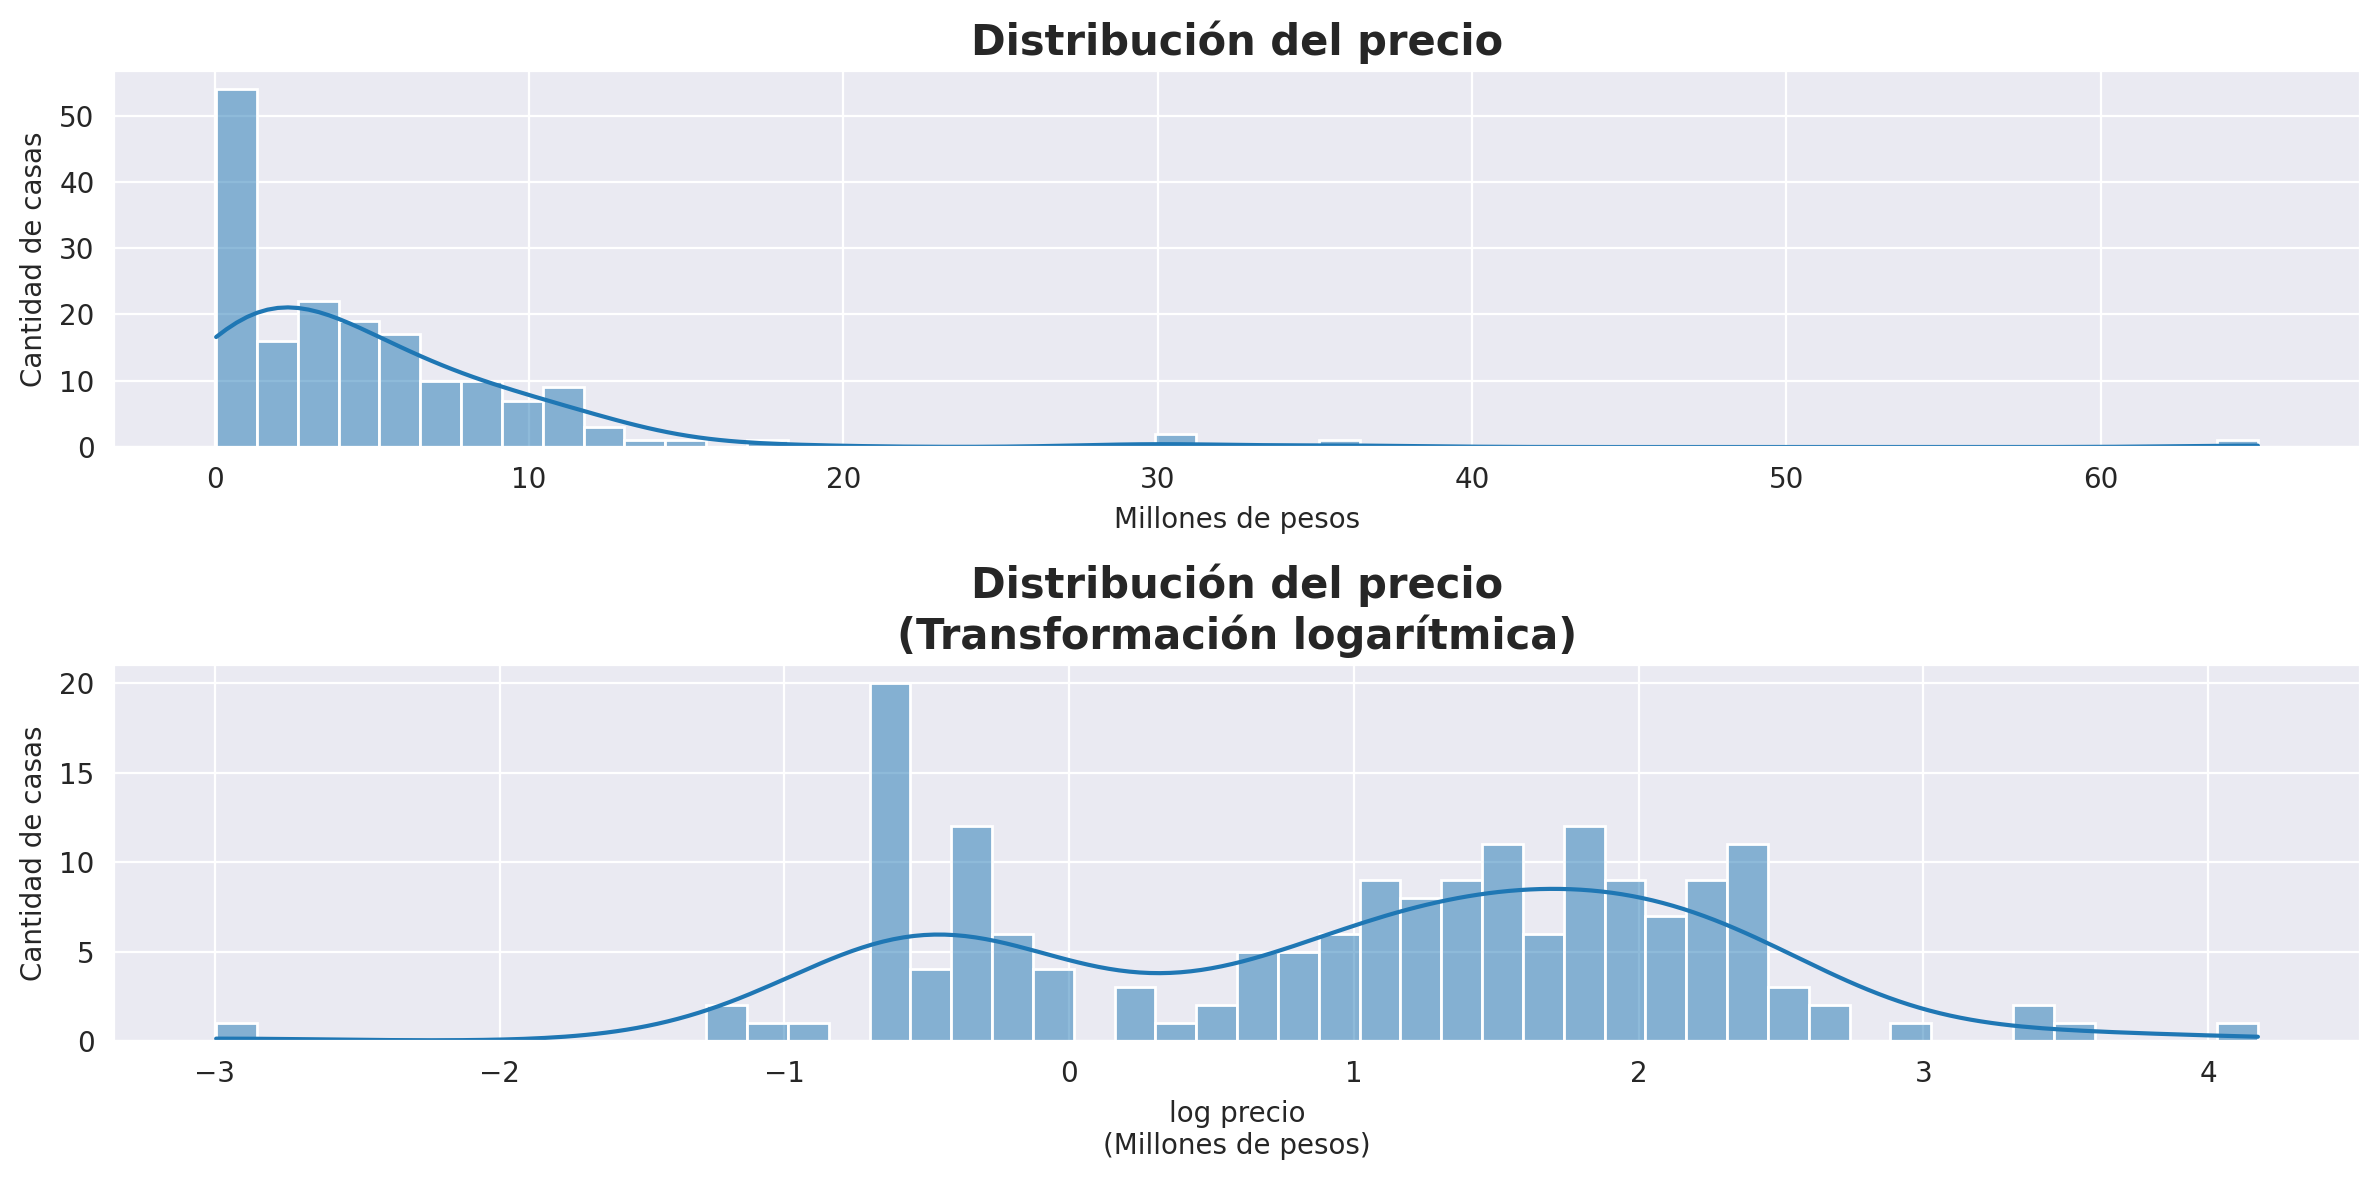

In [16]:
fig, ax = plt.subplots(ncols=1, nrows=2)
sns.histplot(data=data_parking, x=data_parking.price/1000000, 
            kde=True, bins=50, ax=ax[0])
ax[0].set_title("Distribución del precio",
                fontdict={"fontweight": "bold", "fontsize":15})
ax[0].set_xlabel("Millones de pesos")
ax[0].set_ylabel("Cantidad de casas")

sns.histplot(data=data_parking, x=np.log(data_parking.price/1000000), 
            kde=True, bins=50, ax=ax[1])
ax[1].set_title("Distribución del precio\n(Transformación logarítmica)",
                fontdict={"fontweight": "bold", "fontsize":15})
ax[1].set_xlabel("log precio\n(Millones de pesos)")
ax[1].set_ylabel("Cantidad de casas")

plt.subplots_adjust(top=0.85)
plt.tight_layout()
plt.show()

In [17]:
data_parking.describe()

,price,bedrooms,bathrooms,built_area,land_area,parking
count,1.740000e+02,174.000000,174.000000,174.000000,174.000000,174.000000
mean,5.145218e+06,4.011494,3.120690,295.040230,261.086207,1.850575
std,6.920069e+06,1.970853,1.734495,149.581202,162.852636,1.020356
min,5.000000e+04,2.000000,0.000000,60.000000,60.000000,1.000000
25%,7.900000e+05,3.000000,2.000000,200.000000,180.000000,1.000000
50%,3.500000e+06,4.000000,3.000000,261.000000,221.000000,2.000000
75%,6.950000e+06,4.000000,3.000000,387.000000,300.000000,2.000000
max,6.500000e+07,20.000000,11.000000,1236.000000,936.000000,6.000000


In [18]:
# El valor mínimo de price es de 50000, este valor pertenece al precio de renta
# El valor máximo pertenece a una propiedad pensada en ser usada como negocio
# por lo que no se corresponde con el resto de los datos.
# Ambos valores se eliminarán
data_parking = data_parking.drop(index=[data_parking.price.argmin(), data_parking.price.argmax()])

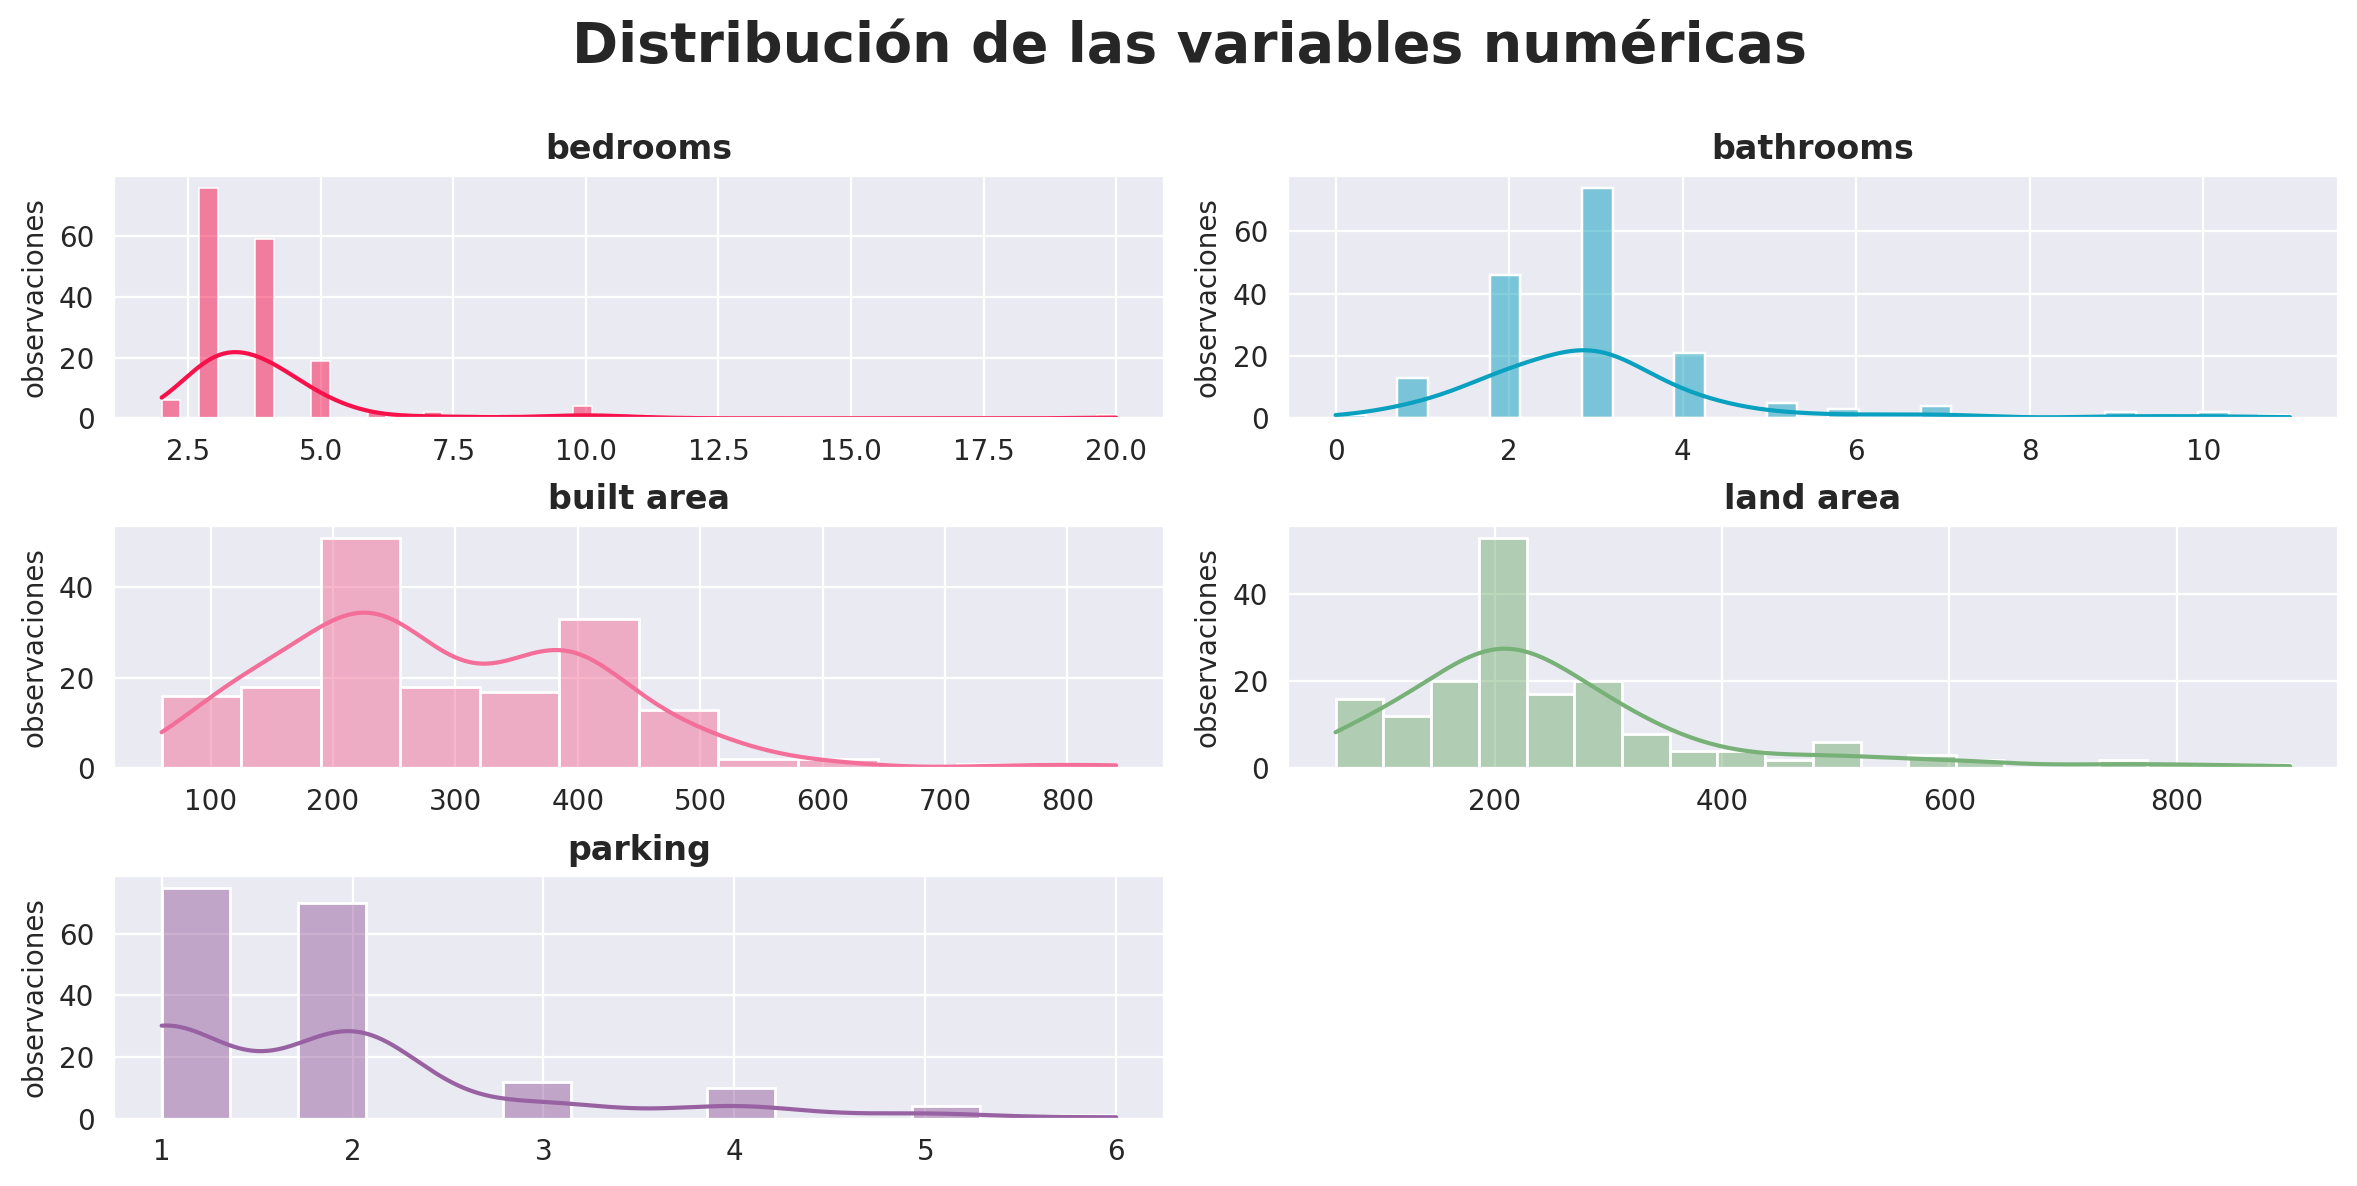

In [19]:
# Grágico de la distribución de las variables numéricas
fig, ax = plt.subplots(ncols=2, nrows=3)
ax = ax.flat
columnas_numericas_parking = data_parking.select_dtypes(include=["float", "int"]).columns
columnas_numericas_parking = columnas_numericas_parking.drop(["price"])

for num, column in enumerate(columnas_numericas_parking):
    sns.histplot(data=data_parking, x=column, color=palette[num],
                 kde=True, ax=ax[num])
    ax[num].set_title(f"{column.replace('_', ' ')}", 
                      fontsize=12, fontweight="bold")
    ax[num].set_xlabel("")
    ax[num].set_ylabel("observaciones", fontsize=10)


fig.tight_layout()
plt.subplots_adjust(top=0.85)
fig.suptitle("Distribución de las variables numéricas",
             fontsize=20, fontweight="bold")
plt.delaxes(ax[5])

plt.show()

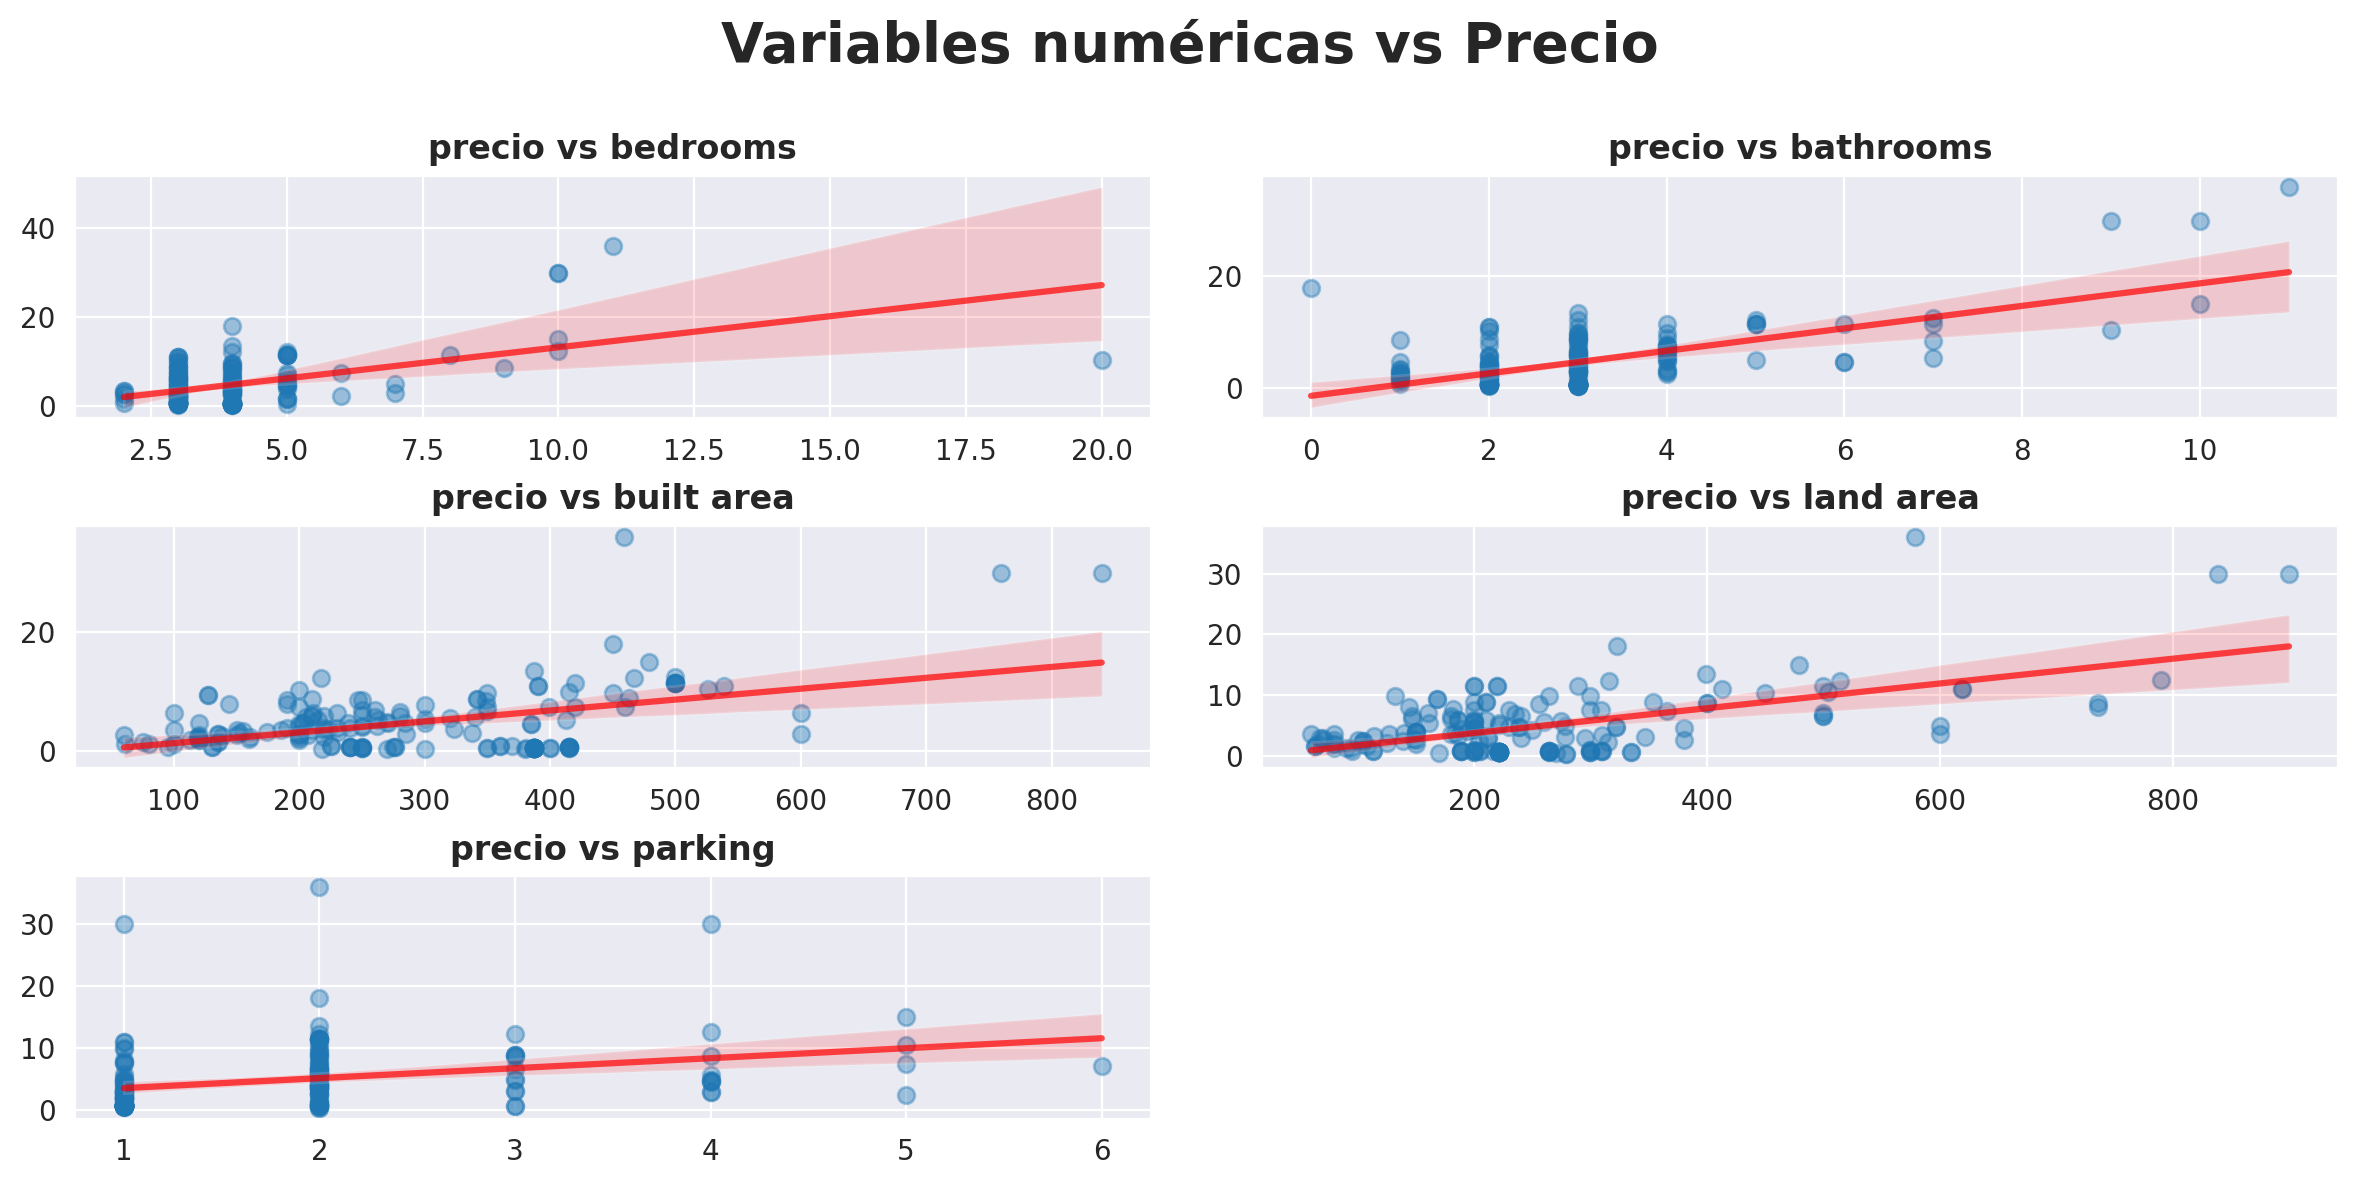

In [20]:
# Relación de las variables numéricas con la variable respuesta
fig, ax = plt.subplots(ncols=2, nrows=3)
ax = ax.flat
for i, column in enumerate(columnas_numericas_parking):
    sns.regplot(x=data_parking[column], y=data_parking.price/1000000,
                scatter_kws={"alpha": 0.4},
                line_kws={"color": "red", "alpha":0.7},
                ax=ax[i])
    ax[i].set_title(f"precio vs {column.replace('_', ' ')}",
                    fontdict={"size": "12",
                              "weight":"bold"})
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")

    
plt.tight_layout()
plt.suptitle("Variables numéricas vs Precio",
             size=20, weight="bold")
plt.subplots_adjust(top=0.85)
plt.delaxes(ax=ax[5])
plt.show()

Todas las variables parecen tener una correlación prositiva con el precio.

En el caso de la variable parking esta correlación parece ser más debil

In [21]:
matriz_corr_parking = data_parking.select_dtypes(include=["float", "int"])
matriz_corr_parking = matriz_corr_parking.rename(columns={"built_area": "built area",
                                          "land_area": "land area"})
matriz_corr_parking = matriz_corr_parking.corr(method="pearson")
matriz_corr_parking

,price,bedrooms,bathrooms,built area,land area,parking
price,1.000000,0.516140,0.640933,0.462794,0.585060,0.313029
bedrooms,0.516140,1.000000,0.767930,0.466503,0.430448,0.370832
bathrooms,0.640933,0.767930,1.000000,0.605363,0.486844,0.311218
built area,0.462794,0.466503,0.605363,1.000000,0.483939,0.091361
land area,0.585060,0.430448,0.486844,0.483939,1.000000,0.365240
parking,0.313029,0.370832,0.311218,0.091361,0.365240,1.000000


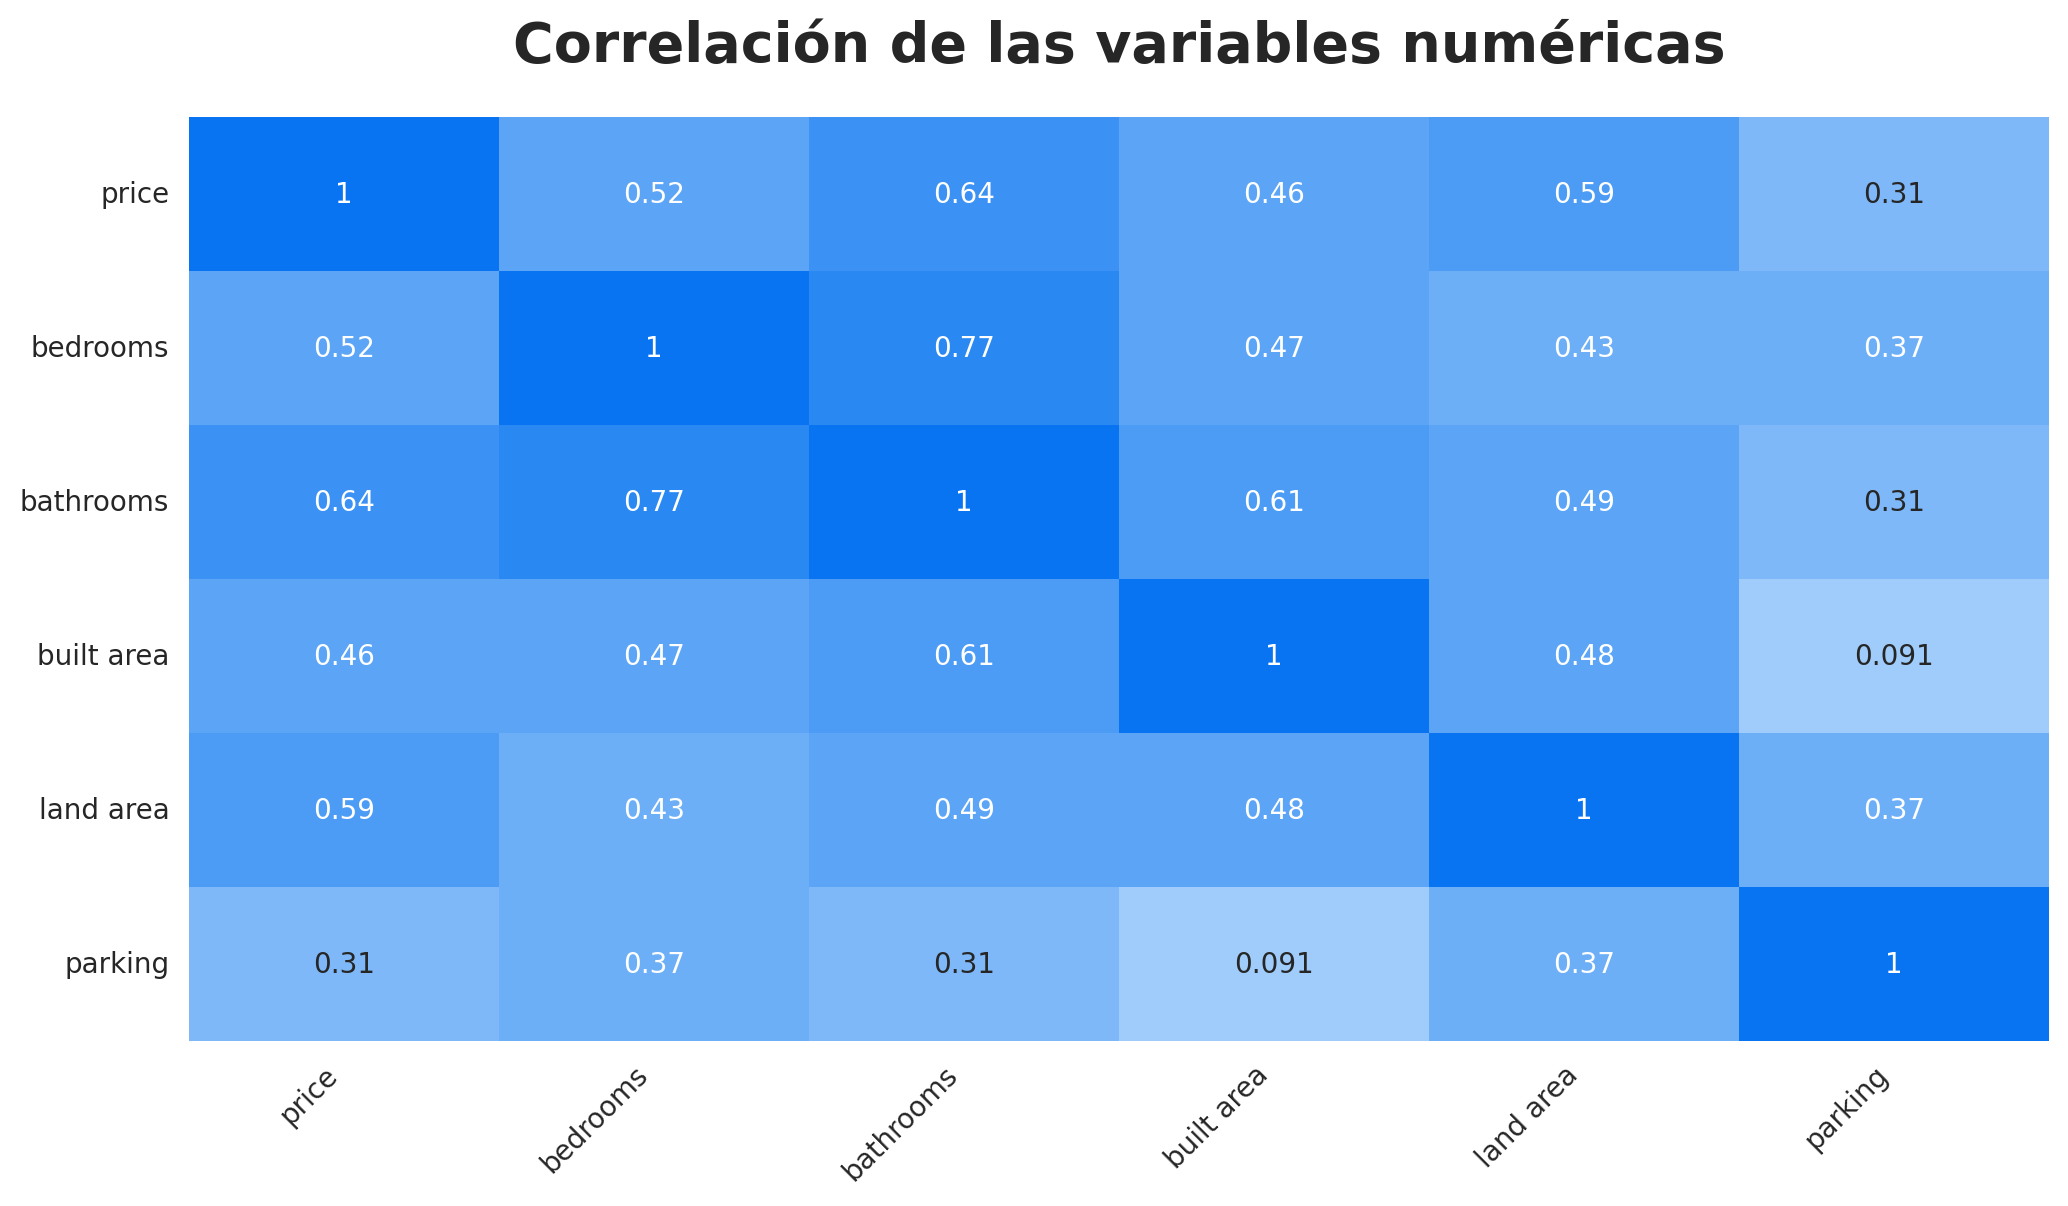

In [22]:
corr_palette = ["#9fccfa", "#8ec2f9", "#7eb8f8", "#6daff7", 
                "#5ca5f6", "#4c9bf5", "#3b91f4", "#2a88f3", 
                "#1a7ef2", "#0974f1"]

ax = sns.heatmap(matriz_corr_parking,
            annot=True,
            cbar=False,
            cmap=corr_palette)

ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    ha="right"
)

plt.title("Correlación de las variables numéricas",
          fontsize=20, fontweight="bold", pad=20)
plt.show()

La variable que tiene mayor correlación con price es bathroom

La variable parking es la que tiene una menor correlación con price

La variable bathroom y bedroom tienen una alta correlación entre ellas

## Datos sin variable parking
Se analizarán los datos eliminando la variable parking, lo que implica eliminar la variable con menor correlación con al variable respuesta a cambio de recuperar 72 datos del resto de variables

In [23]:
# Se define un dataframe sin la columna parking
data = df.drop(columns="parking")

In [24]:
# Información sobre las variables
# No se tienen datos nulos en las variables
data.describe()

,price,bedrooms,bathrooms,built_area,land_area
count,2.460000e+02,246.000000,246.000000,246.000000,246.000000
mean,5.231677e+06,3.983740,2.979675,284.772358,286.223577
std,6.787422e+06,2.099499,1.819283,160.537633,263.431319
min,5.000000e+04,1.000000,0.000000,1.000000,60.000000
25%,8.872880e+05,3.000000,2.000000,181.250000,168.500000
50%,3.325000e+06,3.000000,3.000000,250.000000,220.000000
75%,7.150000e+06,4.000000,3.000000,386.500000,300.000000
max,6.500000e+07,20.000000,11.000000,1236.000000,2629.000000


In [25]:
# Se elimina el dato que contiene land_area de 2629 m2, ya que
# representa un outlier y la propiedad corresponde a una casa
# no terminada, por lo que no es representativo del resto de los datos
data = data.drop(index=data.query("land_area>2000").index)

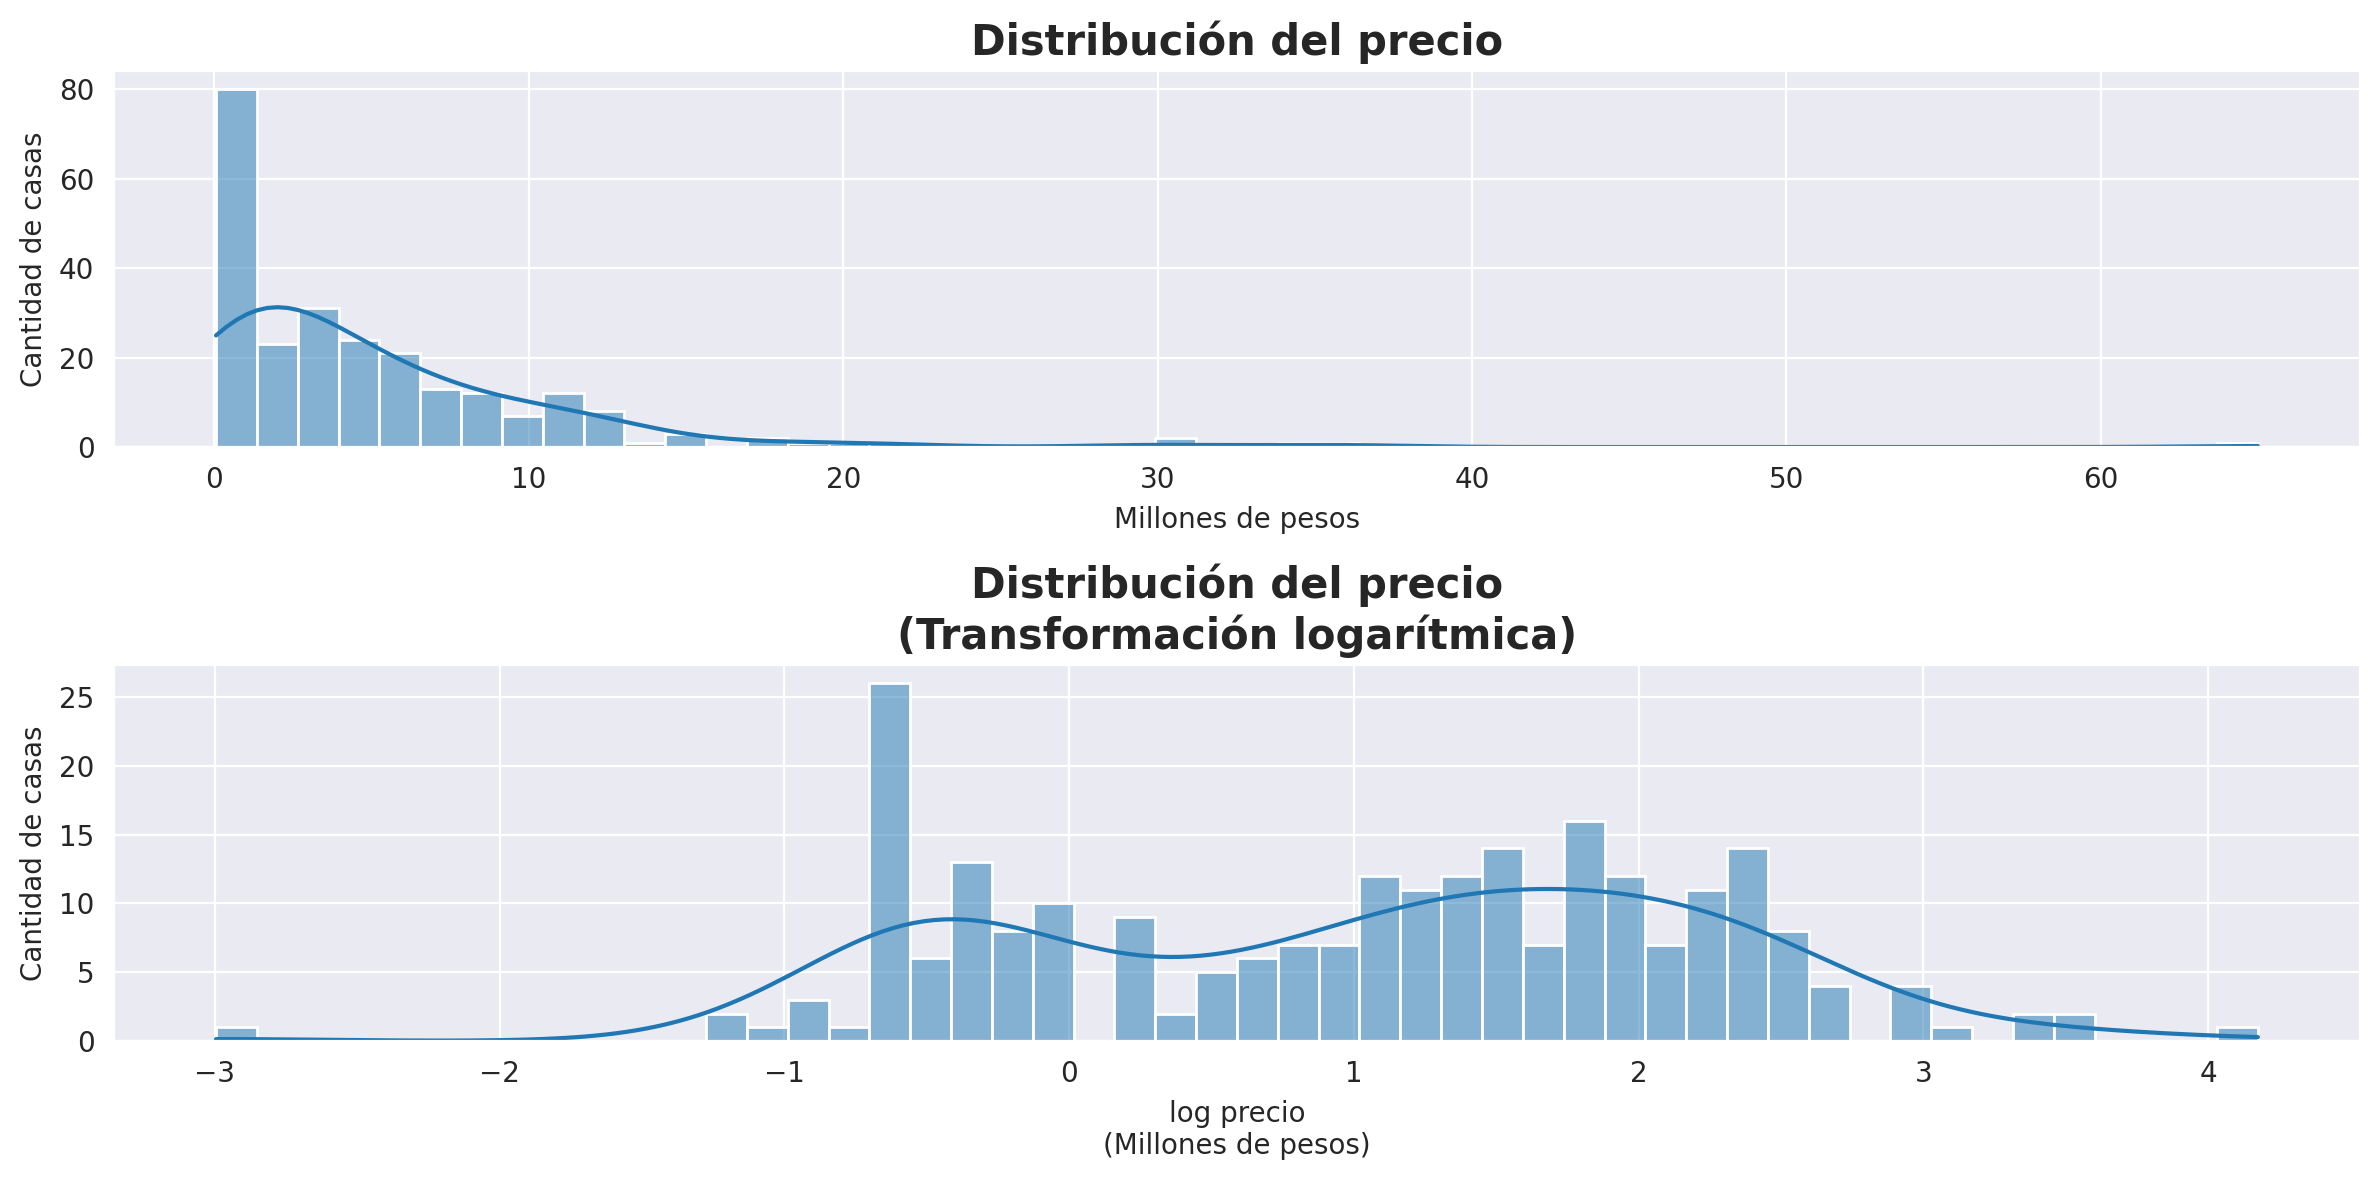

In [26]:
fig, ax = plt.subplots(ncols=1, nrows=2)
sns.histplot(data=data, x=data.price/1000000, 
            kde=True, bins=50, ax=ax[0])
ax[0].set_title("Distribución del precio",
                fontdict={"fontweight": "bold", "fontsize":15})
ax[0].set_xlabel("Millones de pesos")
ax[0].set_ylabel("Cantidad de casas")

sns.histplot(data=data, x=np.log(data.price/1000000), 
            kde=True, bins=50, ax=ax[1])
ax[1].set_title("Distribución del precio\n(Transformación logarítmica)",
                fontdict={"fontweight": "bold", "fontsize":15})
ax[1].set_xlabel("log precio\n(Millones de pesos)")
ax[1].set_ylabel("Cantidad de casas")

plt.tight_layout()
plt.show()

La distribución de la variables respuesta es muy similar

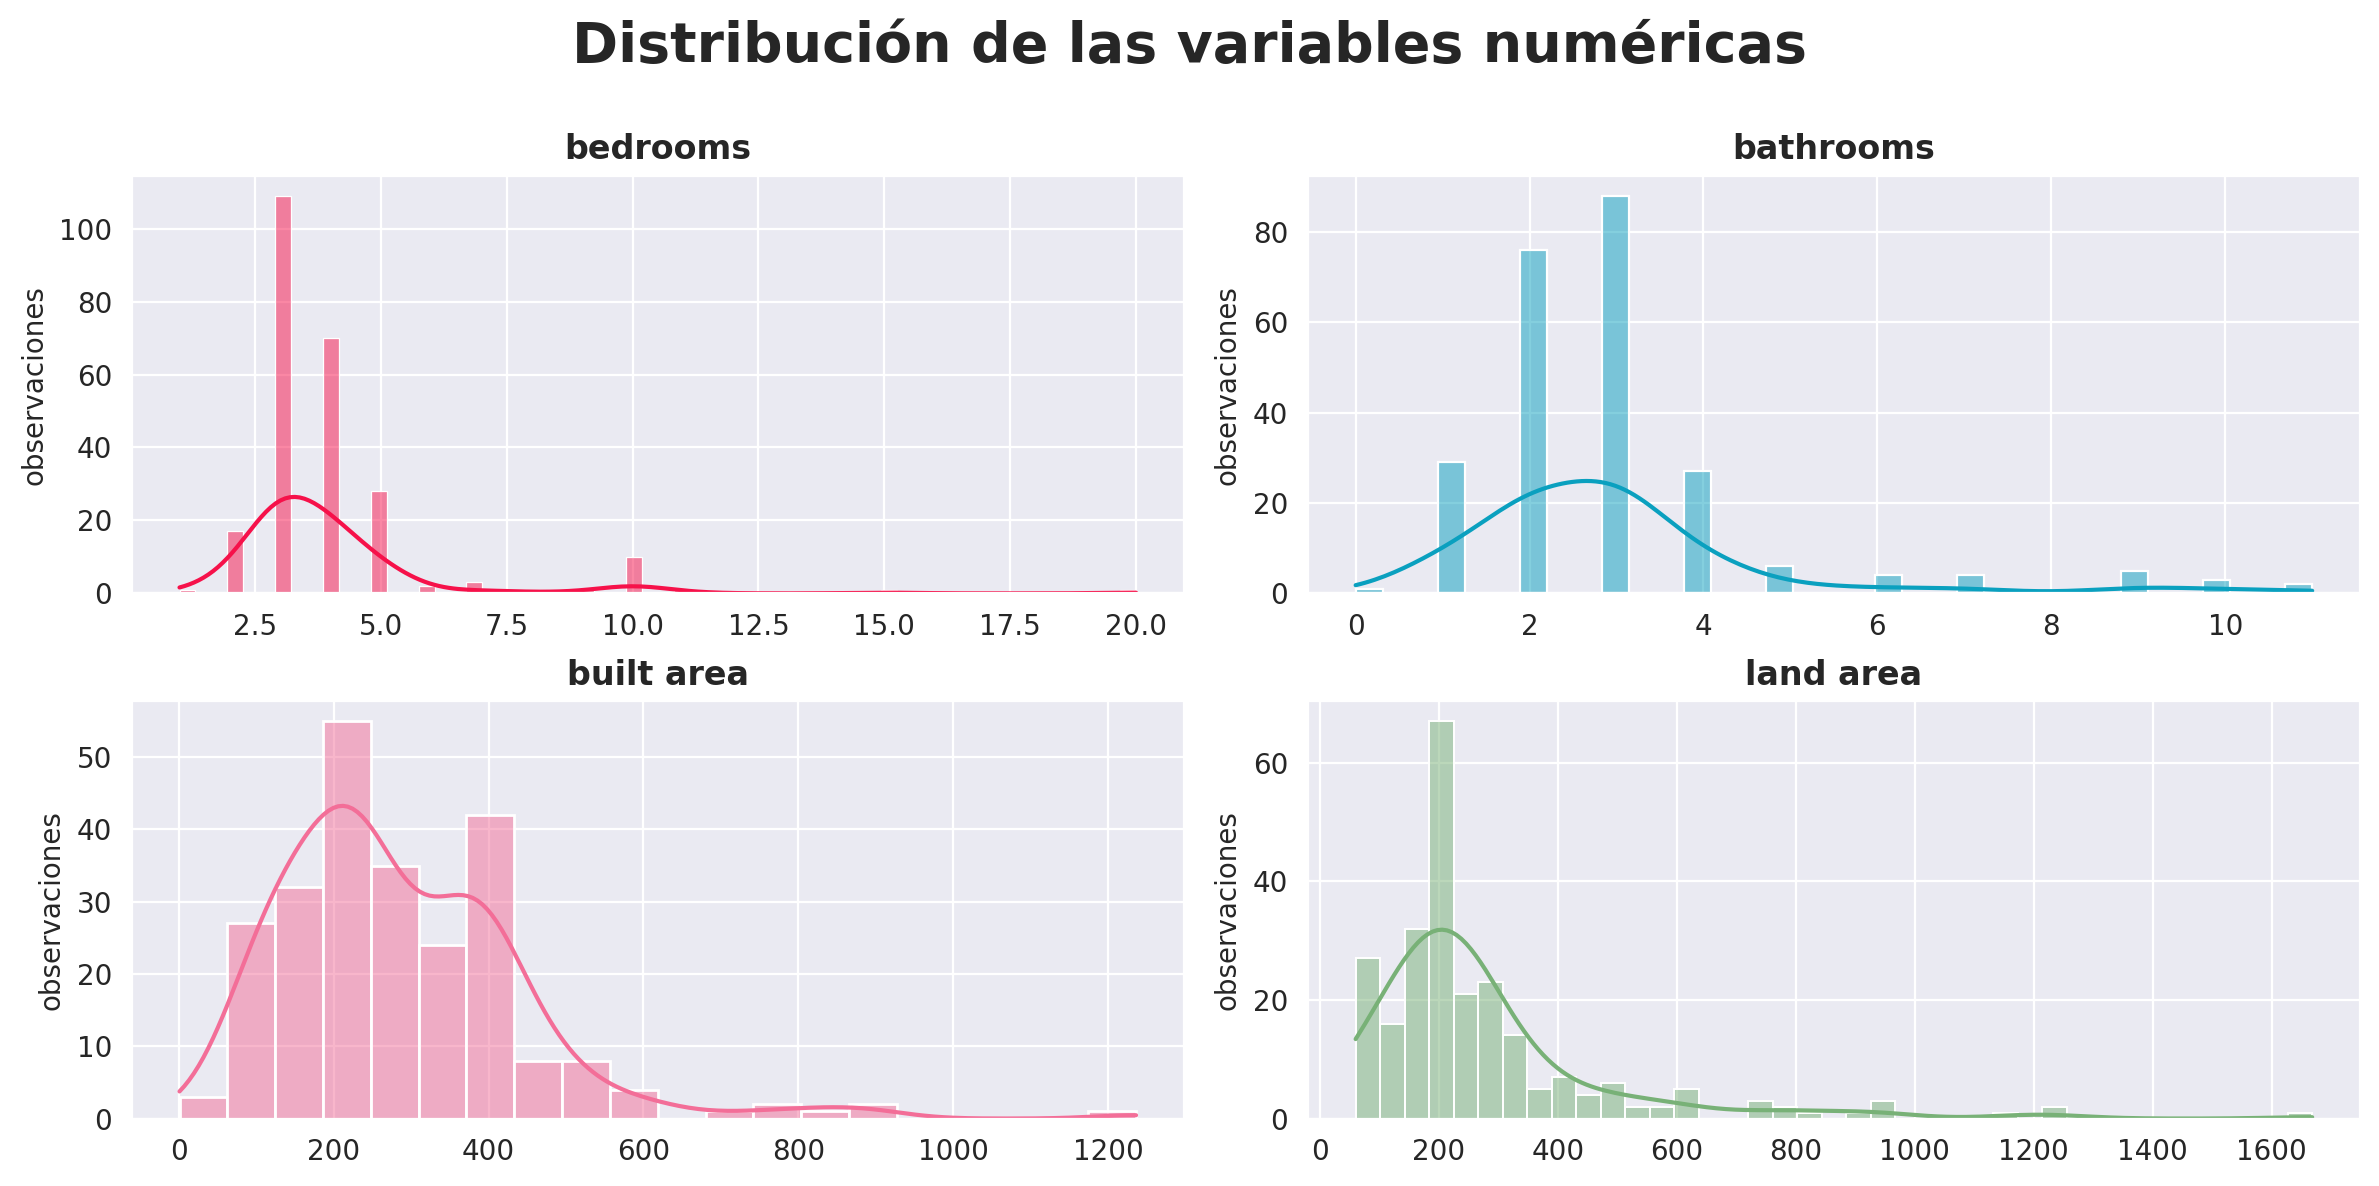

In [27]:
# Grágico de la distribución de las variables numéricas
fig, ax = plt.subplots(ncols=2, nrows=2)
ax = ax.flat
columnas_numericas = data.select_dtypes(include=["float", "int"]).columns
columnas_numericas = columnas_numericas.drop(["price"])

for num, column in enumerate(columnas_numericas):
    sns.histplot(data=data, x=column, color=palette[num],
                 kde=True, ax=ax[num])
    ax[num].set_title(f"{column.replace('_', ' ')}", 
                      fontsize=12, fontweight="bold")
    ax[num].set_xlabel("")
    ax[num].set_ylabel("observaciones", fontsize=10)


fig.tight_layout()
plt.subplots_adjust(top=0.85)
fig.suptitle("Distribución de las variables numéricas",
             fontsize=20, fontweight="bold")


plt.show()

La distribución de las variables se mantiene muy similar

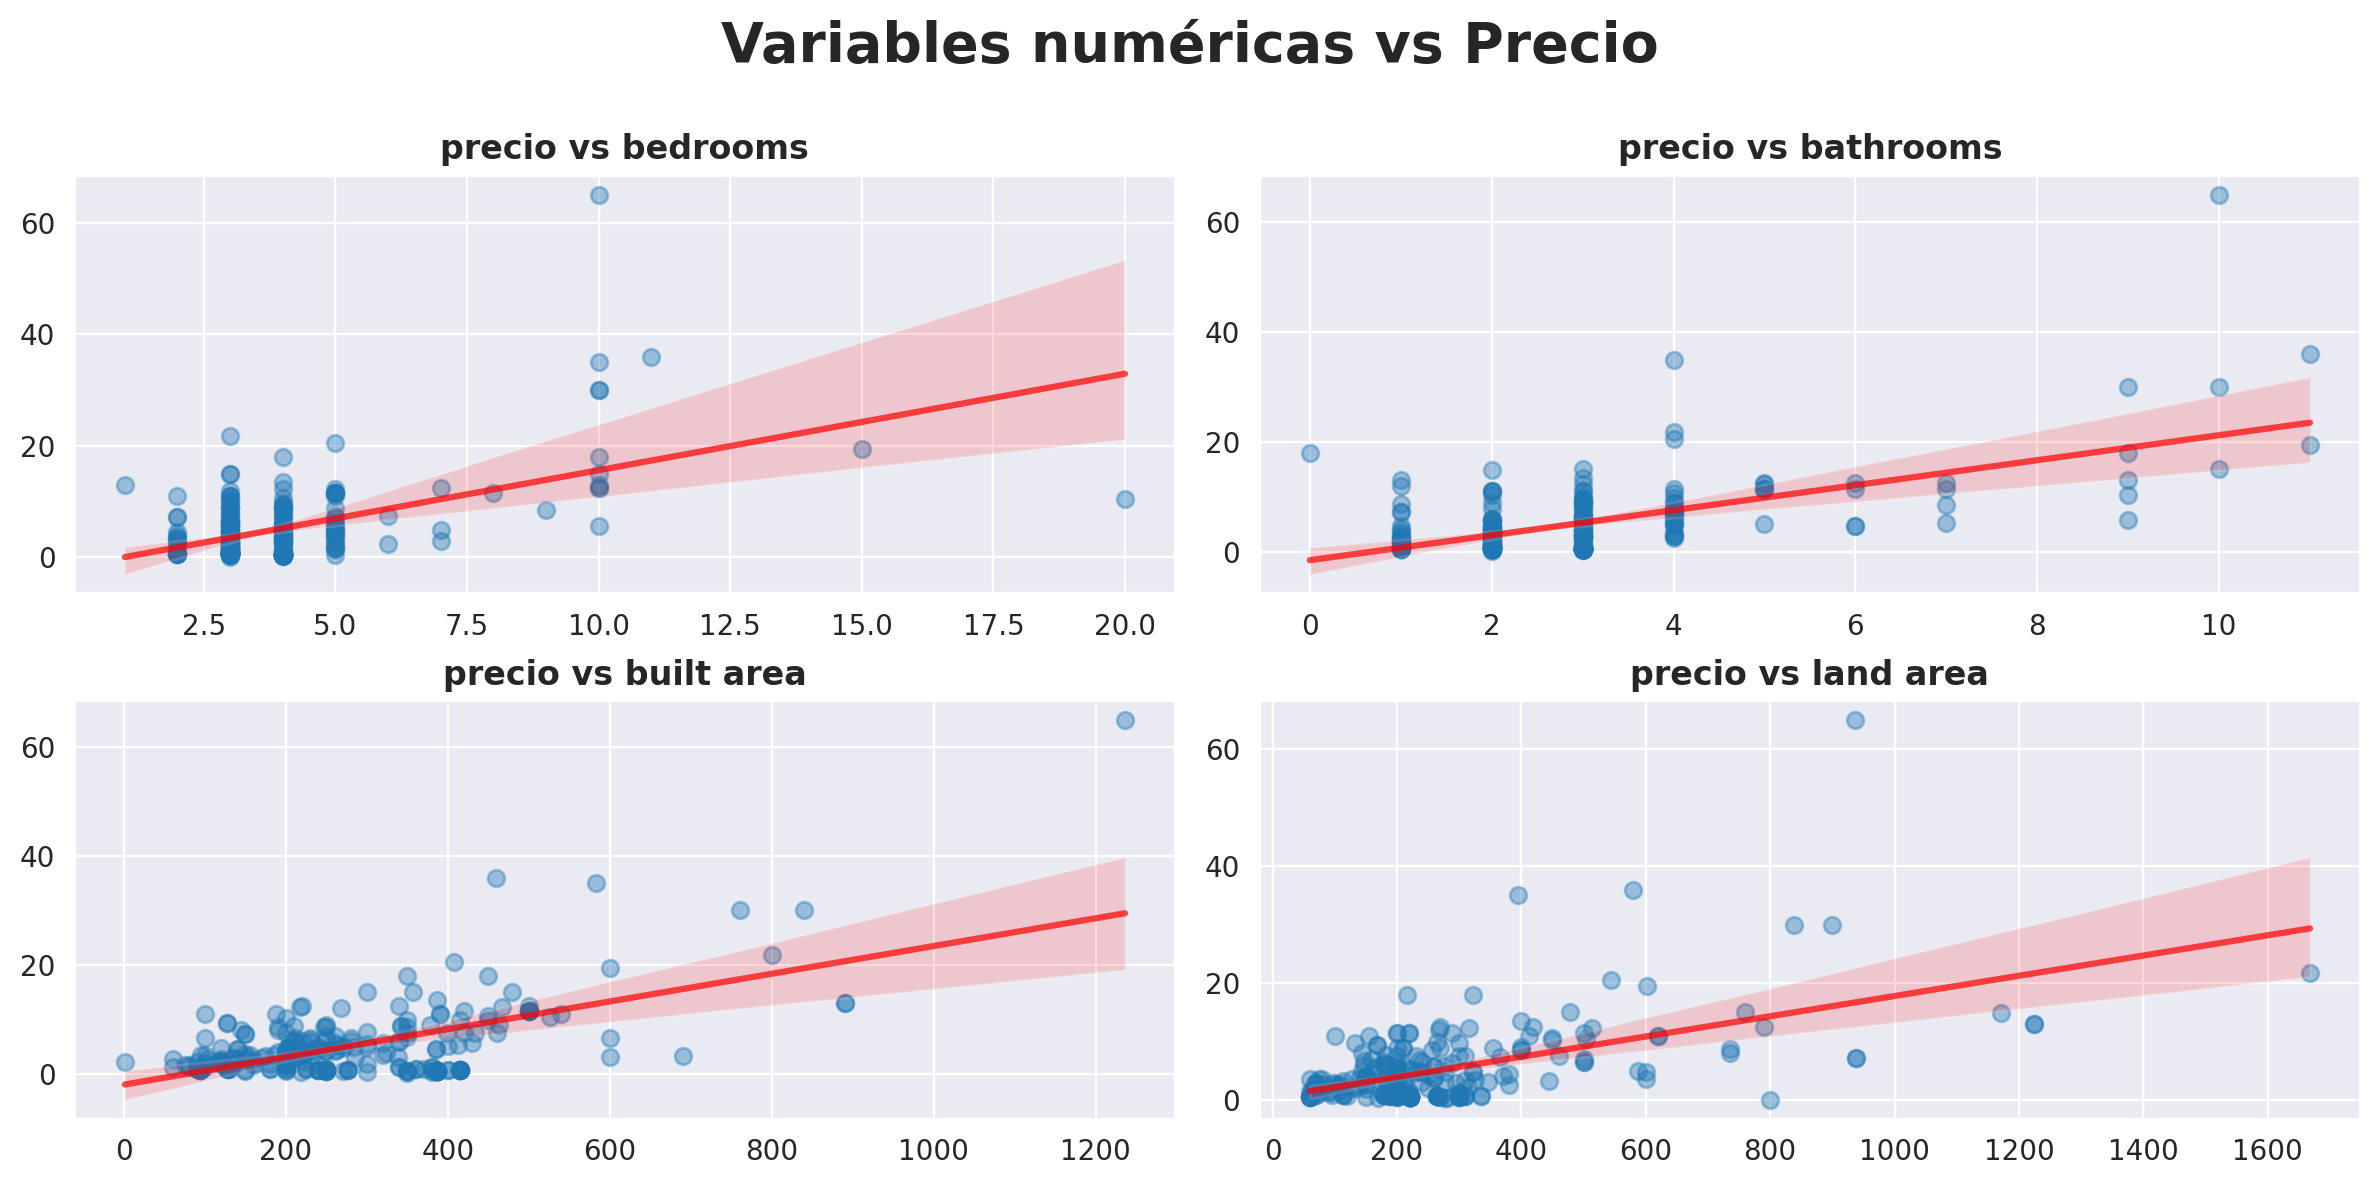

In [28]:
# Relación de las variables numéricas con la variable respuesta
fig, ax = plt.subplots(ncols=2, nrows=2)
ax = ax.flat
for i, column in enumerate(columnas_numericas):
    sns.regplot(x=data[column], y=data.price/1000000,
                scatter_kws={"alpha": 0.4},
                line_kws={"color": "red", "alpha":0.7},
                ax=ax[i])
    ax[i].set_title(f"precio vs {column.replace('_', ' ')}",
                    fontdict={"size": "12",
                              "weight":"bold"})
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")

    
plt.tight_layout()
plt.suptitle("Variables numéricas vs Precio",
             size=20, weight="bold")
plt.subplots_adjust(top=0.85)
plt.show()

La relación lineal entre las variables predictoras y la variable respuesta se mantiene, pero los intervalos de confianza son más amplios para el caso de las variables land_area y built_area

In [29]:
matriz_corr = data.select_dtypes(include=["float", "int"])
matriz_corr = matriz_corr.rename(columns={"built_area": "built area",
                                          "land_area": "land area"})
matriz_corr = matriz_corr.corr(method="pearson")
matriz_corr

,price,bedrooms,bathrooms,built area,land area
price,1.000000,0.534435,0.609383,0.602184,0.553098
bedrooms,0.534435,1.000000,0.823098,0.459915,0.270305
bathrooms,0.609383,0.823098,1.000000,0.600862,0.353692
built area,0.602184,0.459915,0.600862,1.000000,0.595397
land area,0.553098,0.270305,0.353692,0.595397,1.000000


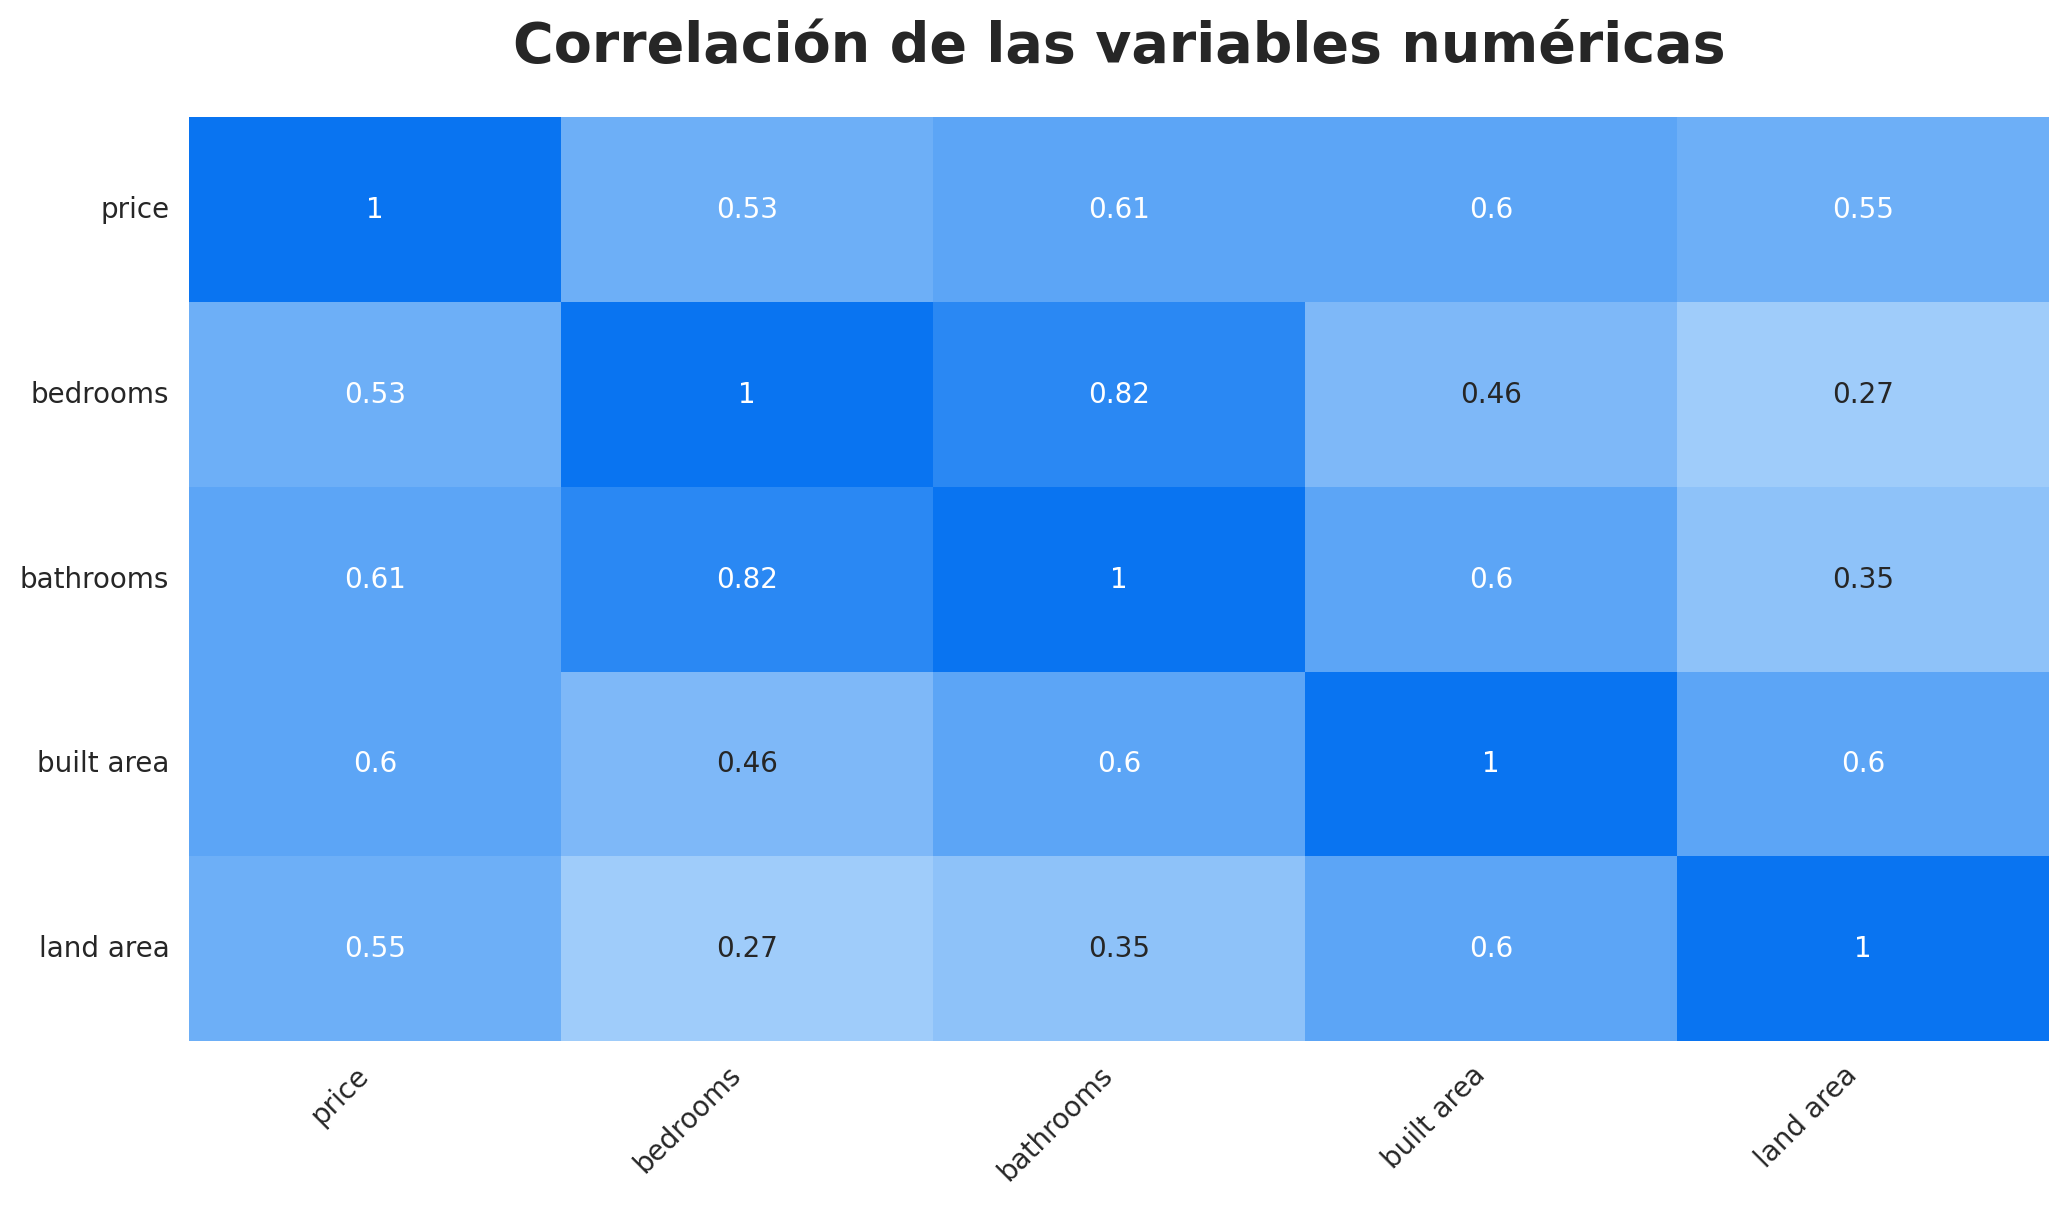

In [30]:
corr_palette = ["#9fccfa", "#8ec2f9", "#7eb8f8", "#6daff7", 
                "#5ca5f6", "#4c9bf5", "#3b91f4", "#2a88f3", 
                "#1a7ef2", "#0974f1"]

ax = sns.heatmap(matriz_corr,
            annot=True,
            cbar=False,
            cmap=corr_palette)

ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    ha="right"
)

plt.title("Correlación de las variables numéricas",
          fontsize=20, fontweight="bold", pad=20)
plt.show()

## Variables categóricas

In [31]:
# Antes de realizar el análisis de variables categóricas 
# se elimina la variable description ya que no aporta información 
# útil en este punto
data = data.drop(columns="description")
data.describe(include="object")

,zip_code
count,245
unique,39
top,68026
freq,32


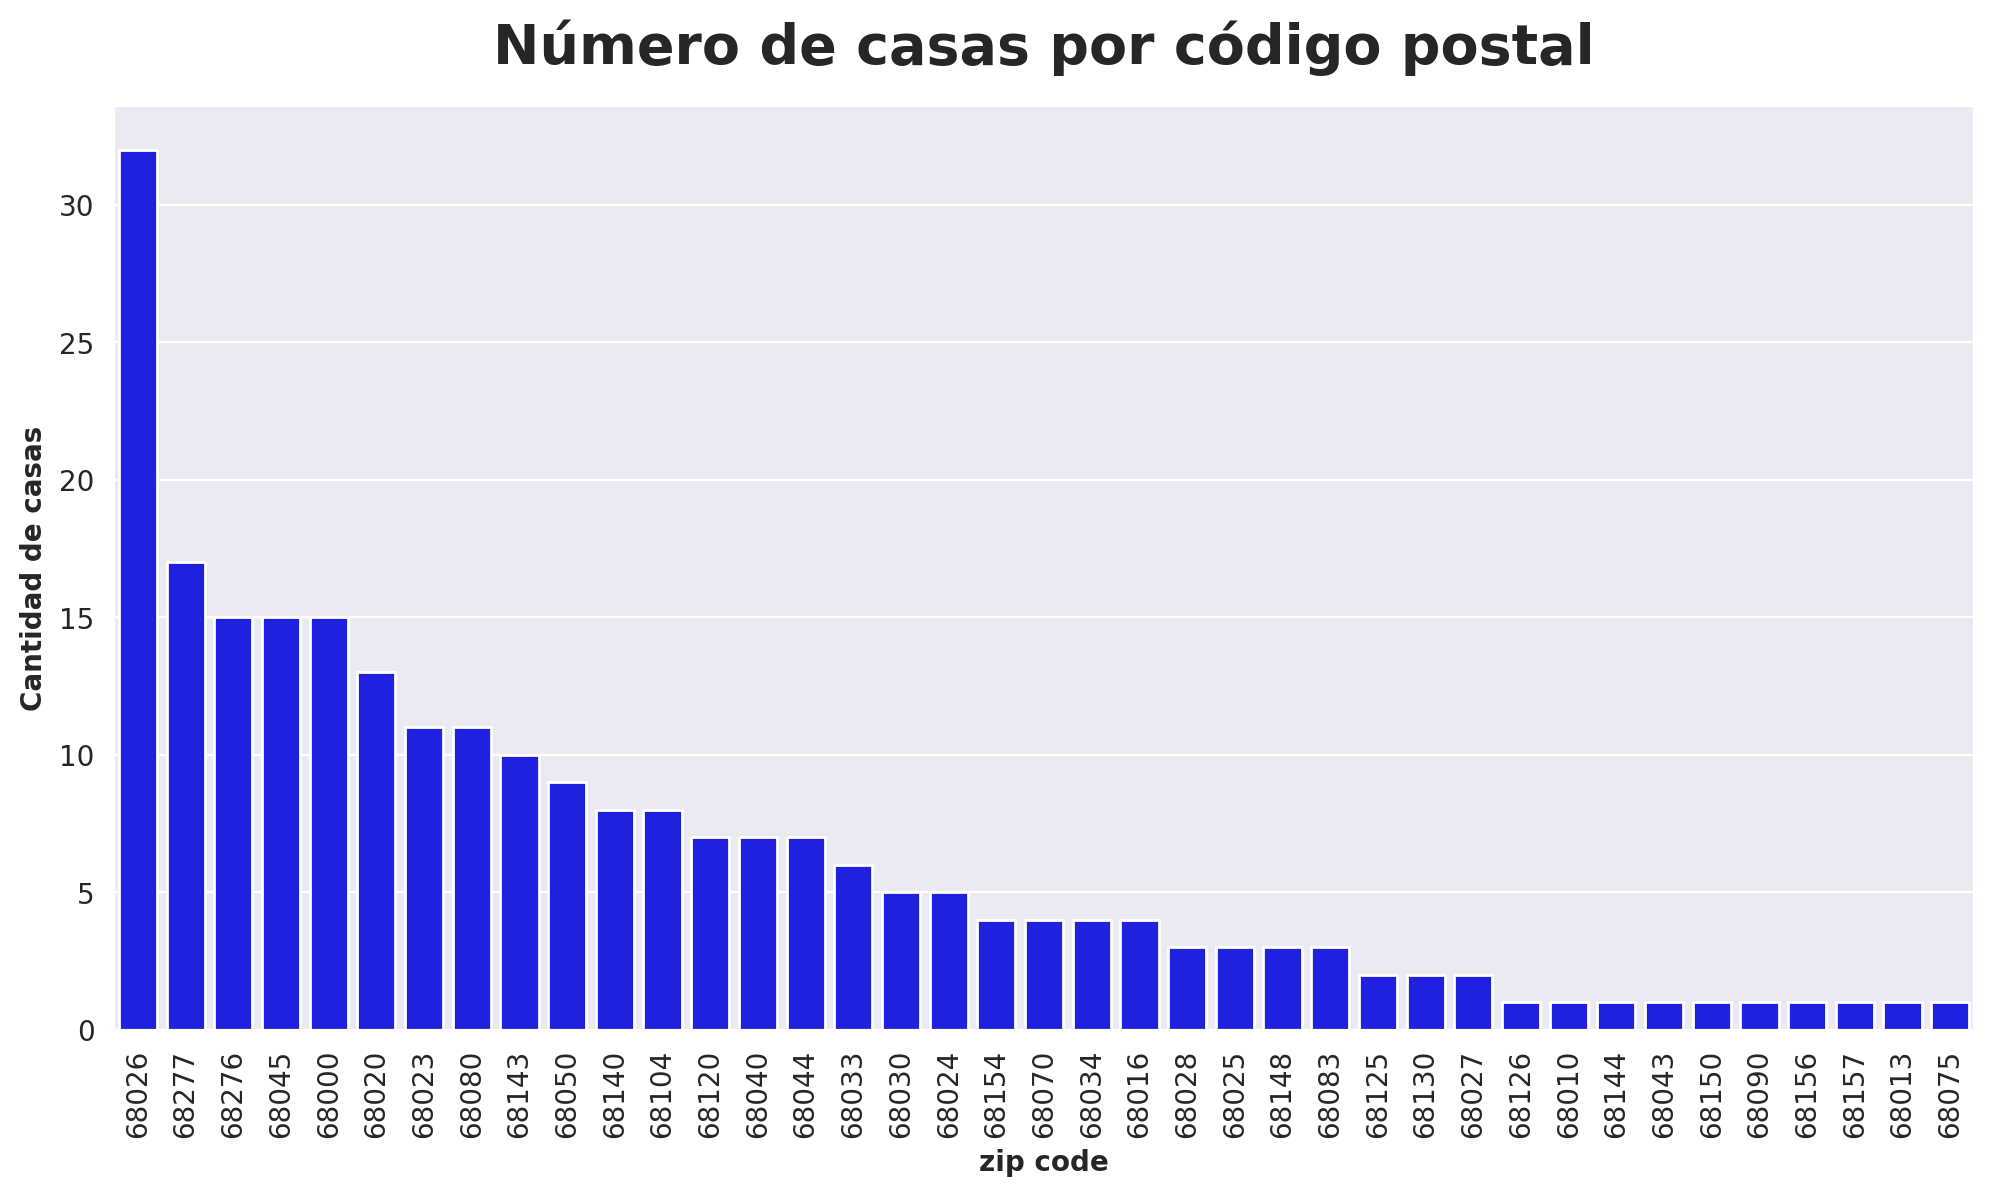

In [32]:
# Distribución de variable zip_code

# Se agrupan los datos con base en los zip codes
zip_code_count = data.groupby("zip_code").zip_code.count()
zip_code_count = zip_code_count.sort_values(ascending=False)

# Se frafican los datos agrupados
fig, ax = plt.subplots()
sns.barplot(x=zip_code_count.index, 
            y=zip_code_count.values,
            orient="v", 
            color="blue", 
            ax=ax)

ax.set_title("Número de casas por código postal",
            size=20, weight="bold", pad=15)
ax.set_xlabel("zip code", weight="bold") 
ax.set_ylabel("Cantidad de casas", weight="bold") 
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90
)

plt.show()

Se agruparán los códigos postales por zonas, con el fin de que sea más eficiente entrenar el modelo.

El criterio de agrupación será la ubicación geográfica de los zip codes. En total serán 4 grupos: 
* Noreste
* Noroeste
* Sureste
* Suroeste

In [33]:
# Se crea un dataframe con las coordenadas de los diferentes códigos postales
cp = np.sort(df.zip_code.unique())

latitud = [17.061703699630915, 17.092001299944847, 17.09510725981049, 17.105085483760785, 17.092171455645918,
            17.099173793208067, 17.092327885287663, 17.083785986520528, 17.10487858486399, 
            17.08513539138772, 17.0858305553655, 17.08376744814505, 17.075801225192613, 17.072883660527367, 
            17.076705993498333, 17.095276343458554, 17.091162715327332, 17.082565984377794, 17.077280420008865,
            17.069727370727595, 17.06520862126542, 17.06170272210107, 17.053795102919675, 17.058844616016312,
            17.06778219858433, 17.051249107604686, 17.041460357071156, 17.044600890229297, 17.044734366156586,
            17.061436245889674, 17.072243376362014, 17.0697870458283, 17.067116555445253, 17.05561422281644,
            17.055391563942212, 17.049805361546987, 17.054967512551844, 17.12927545202283, 17.104722]

longitud = [-96.72460431763291, -96.7511139439312,  -96.7430381456221, -96.7453404612184, -96.7062115891465,
             -96.69826331771002, -96.7215422665757, -96.69678582744157, -96.7115412599079, 
             -96.71079107413293, -96.7023161721296, -96.74130490891585, -96.74354447976008, -96.73753782743624, 
             -96.72312294506077, -96.73565506072806, -96.71482013498873, -96.7297786677104, -96.71403571968861,
             -96.72697041640977, -96.73078259919431, -96.71538919346905, -96.72246468052133, -96.73484121455897,
             -96.7110142557341, -96.71739605825358, -96.70755084342801, -96.71124581593696, -96.71790427203122,
             -96.74649286220549, -96.76023934361022, -96.75154757816586, -96.7438253298391, -96.74265388788346,
             -96.75347124249357, -96.73687583963638, -96.73609553082933, -96.75805212206828, -96.734167]

ubicacion = pd.DataFrame({
    "cp":cp,
    "latitud": latitud,
    "longitud": longitud
}) 

# Se establecen las coordenadas que se tendrán como referencia
zocalo_oax_lat = 17.0605261
zocalo_oax_lon = -96.7252921 

In [34]:
ubicacion.head()

,cp,latitud,longitud
0,68000,17.061704,-96.724604
1,68010,17.092001,-96.751114
2,68013,17.095107,-96.743038
3,68016,17.105085,-96.745340
4,68020,17.092171,-96.706212


In [35]:
# Se crean funciones para pasarlas como argumentos de la función apply

# Esta función toma como argumentos un código postal, el dataframe "ubicacion" y un valor de referencia. 
# Evalua si la latitud obtenida es mayor que el valor de referencia. 
# Si es mayor devuelve 1 de lo contratio devuelve 0
def asignacion_norte_sur(cp, dataframe, referencia):
    lat = dataframe[dataframe["cp"]==cp].latitud.values
    if lat[0] > referencia:
        return 1
    else:
        return 0


# Esta función toma como argumentos un código postal, el dataframe "ubicacion" y un valor de referencia. 
# Evalua si la longitud obtenida es mayor que el valor de referencia. 
# Si es mayor devuelve 1 de lo contratio devuelve 0
def asignacion_este_oeste(cp, dataframe, referencia):
    lon = dataframe[dataframe["cp"]==cp].longitud.values
    if lon[0] > referencia:
        return 1
    else:
        return 0
    

# Toma los valores de las filas especificadas y las evalua
# para asignar las categorías correspondientes
def group_zip_code(fila):
    if (fila["north"] == 1) and (fila["west"] == 1):
        return "nw"
    elif (fila["north"] == 1) and (fila["west"] == 0):
        return "ne"    
    elif (fila["north"] == 0) and (fila["west"] == 1):
        return "sw"
    elif (fila["north"] == 0) and (fila["west"] == 0):
        return "se"


In [36]:
# Agregar las columnas north y west a mi dataframe
data["north"] = data["zip_code"].apply(asignacion_norte_sur, 
                                       dataframe=ubicacion, 
                                       referencia=zocalo_oax_lat)

data["west"] = data["zip_code"].apply(asignacion_este_oeste, 
                                      dataframe=ubicacion, 
                                      referencia=zocalo_oax_lon)

In [37]:
# Crear la columna location con base en las columnas north y west
data["location"] = data.apply(group_zip_code, axis=1)

## División de train y test

In [38]:
# Se eliminan las columnas que no se usarán para entrenar el modelo
data = data.drop(columns=["zip_code", "north", "west"])

In [39]:
data.head(5)

,price,bedrooms,bathrooms,built_area,land_area,location
0,11000000.0,3.0,3.0,539.0,413.0,nw
1,2500000.0,4.0,4.0,200.0,150.0,ne
2,7500000.0,3.0,3.0,399.0,230.0,nw
3,3400000.0,2.0,2.0,155.0,310.0,nw
4,3500000.0,4.0,4.0,220.0,600.0,ne


### Set de entrenamiento y prueba con transformación logarítmica en la variable respuesta

In [40]:
# Se definene las variables predictoras y la variable objetivo
y = data.price.values
y_log = np.log(y).reshape(-1, 1) # Variable objettivo
X_log = data.drop(columns="price") # Variables predictoras

print(X_log.shape, y_log.shape)


# Se dividen los datos en un set de enrenamiento y uno de prueba
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_log,
    y_log,
    train_size=0.80,
    random_state=1234,
    shuffle=True
)

(245, 5) (245, 1)


### Set de entrenamiento y prueba sin transformación logarítmica en la variable respuesta

In [41]:
# Se definene las variables predictoras y la variable objetivo
y = data.price.values
y = y.reshape(-1, 1) # Variable objettivo
X = data.drop(columns="price") # Variables predictoras

print(X.shape, y.shape)


# Se dividen los datos en un set de enrenamiento y uno de prueba
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.80,
    random_state=1234,
    shuffle=True
)

(245, 5) (245, 1)


In [42]:
print("Partición de entrenamiento")
print("============================")
print(pd.Series(y_train.flatten()).describe().round(0))

Partición de entrenamiento
count         196.0
mean      5346610.0
std       7135750.0
min        320000.0
25%        889322.0
50%       3250000.0
75%       7250000.0
max      65000000.0
dtype: float64


In [43]:
print("Partición de entrenamiento")
print("============================")
print(pd.Series(y_test.flatten()).describe().round(0))

Partición de entrenamiento
count          49.0
mean      4837900.0
std       5277915.0
min         50000.0
25%        749900.0
50%       3750000.0
75%       6800000.0
max      30000000.0
dtype: float64


La distribución de la variable respuesta para el la partición train y test son similares

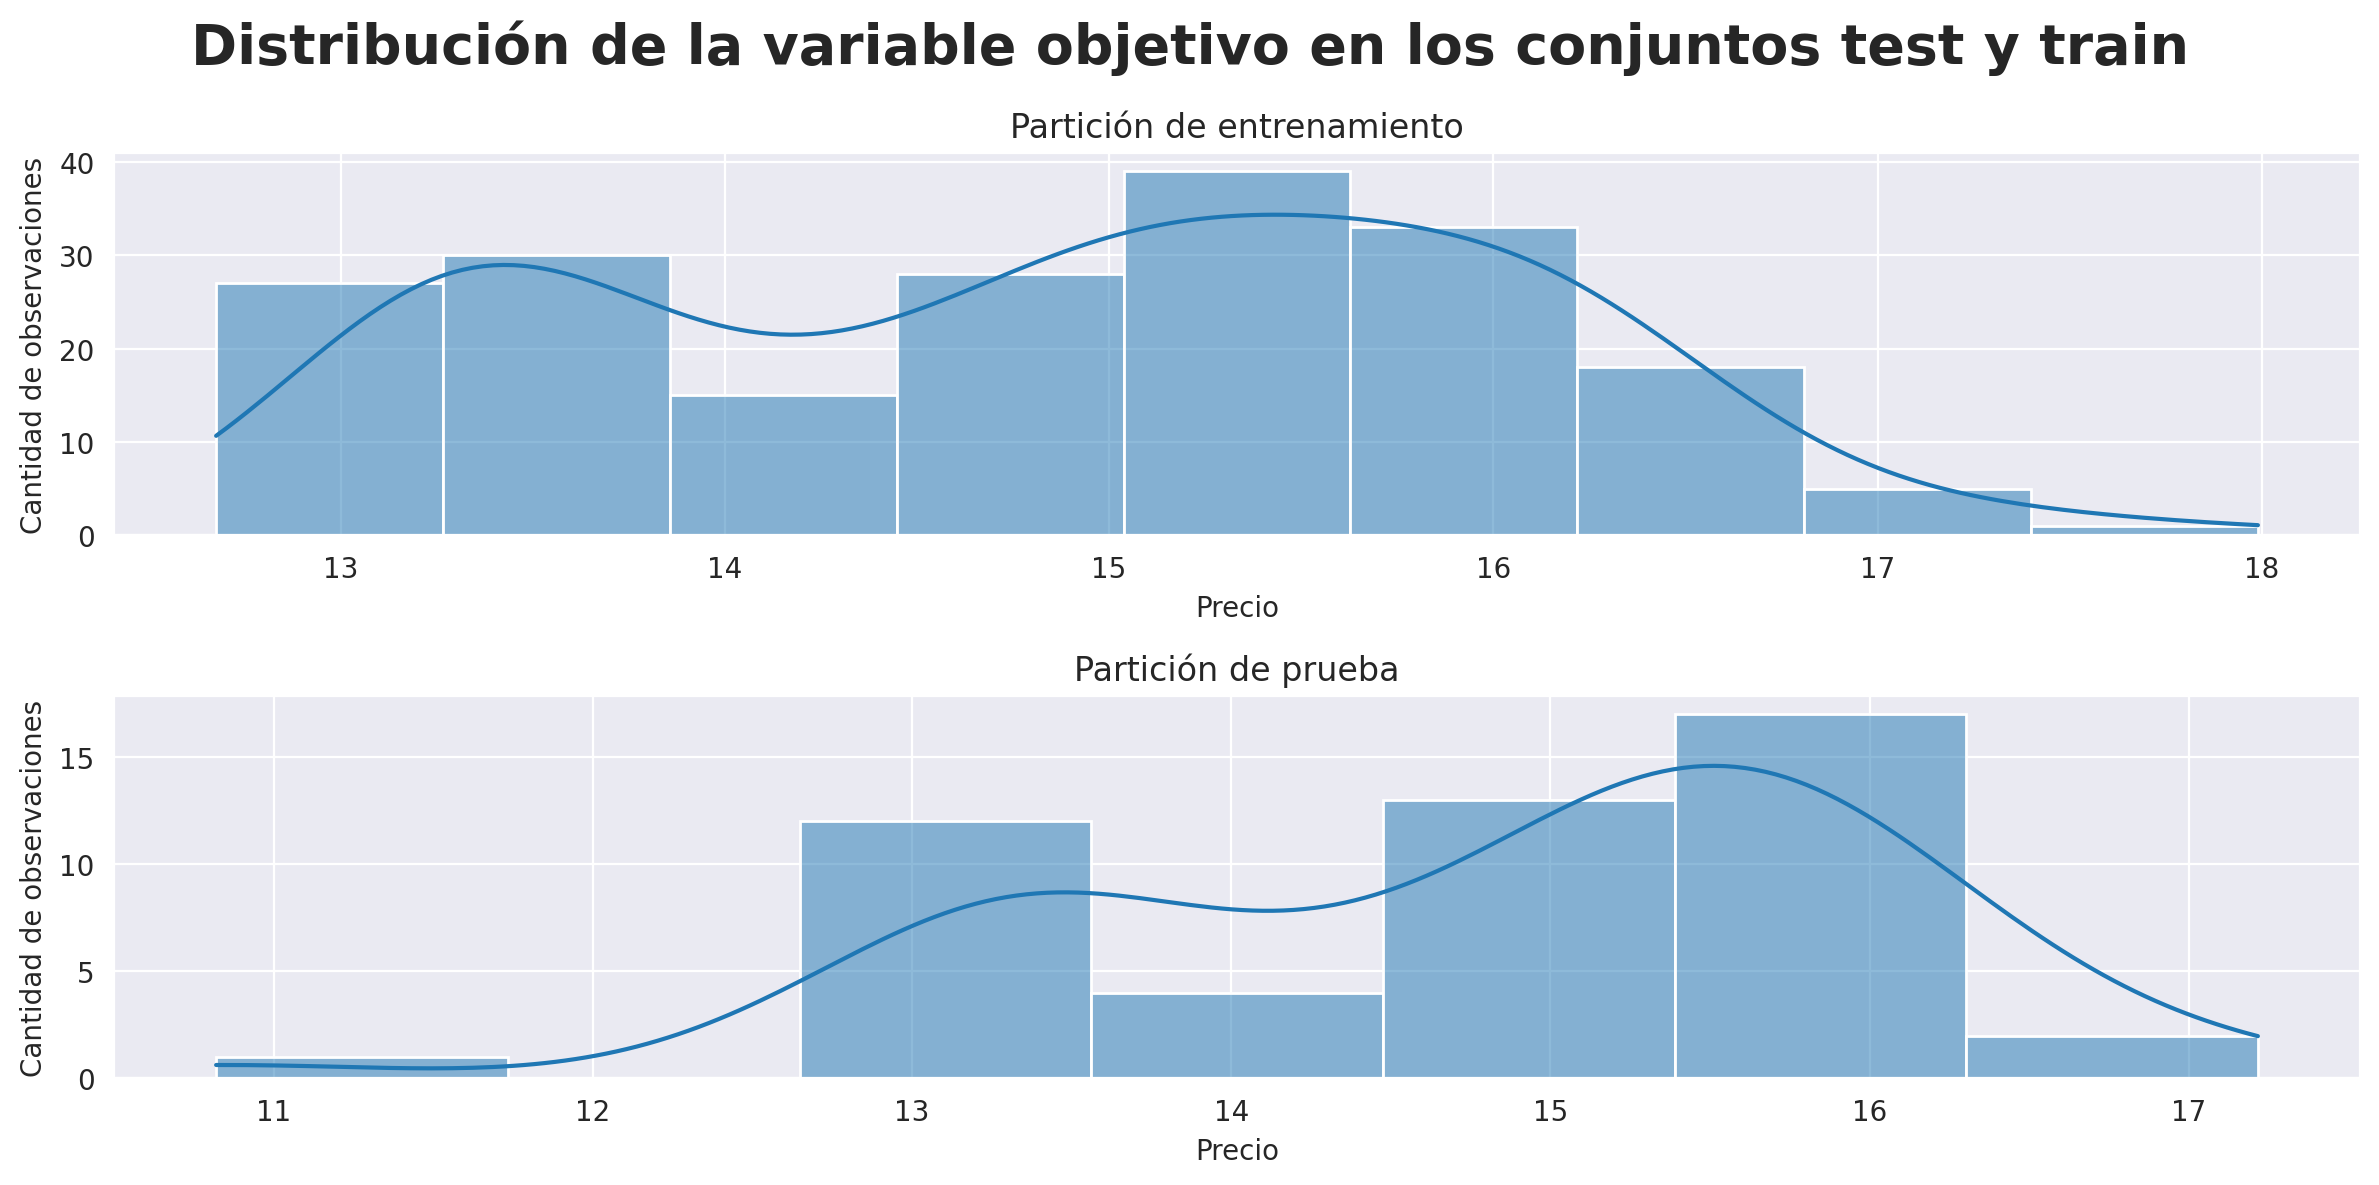

In [44]:
fig, ax = plt.subplots(ncols=1, nrows=2)
ax = ax.flat
sns.histplot(y_train_log.flatten(), ax=ax[0], kde=True)
ax[0].set_title("Partición de entrenamiento")
ax[0].set_ylabel("Cantidad de observaciones")
ax[0].set_xlabel("Precio")

sns.histplot(y_test_log.flatten(), ax=ax[1], kde=True)
ax[1].set_title("Partición de prueba")
ax[1].set_ylabel("Cantidad de observaciones")
ax[1].set_xlabel("Precio")

plt.suptitle("Distribución de la variable objetivo en los conjuntos test y train",
             size=20, weight="bold")
plt.subplots_adjust(top=0.85)
plt.tight_layout()
plt.show()

## Creación del modelo

Se crea un modelo de referencia o baseline para comparar el desempeño de distintos modelos

En este caso el modelo de referencia será el modelo de regresión lineal por MCO

In [45]:
# Se crea un pipeline a través del cual los datos se preprocecen y se asigne un modelo
def preprocesamiento_datos_creacion_pipeline(modelo):
    # Se separan los tipos de variable
    cat_cols = X_train.select_dtypes(include=["object"]).columns.to_list()
    num_cols = X_train.select_dtypes(include=["float", "int"]).columns.to_list()

    # Tranformar las variables numéricas
    numeric_transformer = Pipeline(
                            steps=[
                                ("scaler", StandardScaler())
                            ]
                        )
    
    # Transformación de variables categóricas
    categorical_transformer = Pipeline(
                                steps=[
                                    ("onehot", OneHotEncoder(handle_unknown="ignore",
                                                             sparse_output=False, 
                                                             drop="first"))
                                ]
                            )
    
    preprocessor = ColumnTransformer(
                    transformers=[
                        ("numeric", numeric_transformer, num_cols),
                        ("categorical", categorical_transformer, cat_cols)
                    ],
                    remainder="passthrough"
                ).set_output(transform="pandas")
    
    pipe = Pipeline(
            steps=[
                ("preprocessing", preprocessor),
                ("model", modelo)
            ]
        )
    
    return pipe


In [46]:
# Procesando los datos y ajustando el modelo
linear_pipe = preprocesamiento_datos_creacion_pipeline(LinearRegression()).fit(X=X_train_log, y=y_train_log)
# Gaurdando el modelo ajustado en la variable lienar_model
linear_model = linear_pipe.named_steps["model"]

In [47]:
# Se muestran los valores de los estimadores
print(f"intersección: {linear_model.intercept_[0].round(2)}")
for name, coef in zip(linear_model.feature_names_in_, linear_model.coef_.flatten()):
    print(f"{name}: {coef.round(4)}")

intersección: 14.53
numeric__bedrooms: 0.1606
numeric__bathrooms: 0.2591
numeric__built_area: -0.1061
numeric__land_area: 0.4523
categorical__location_nw: 0.6256
categorical__location_se: 0.2087
categorical__location_sw: -0.042


El modelo estima que dos varibales tienen una relación negativa con el precio: built_area y location_sw

In [171]:
# Valores observados vs predichos
linear_predict = linear_pipe.predict(X_test)
linear_model_predictions = pd.DataFrame(
    {
    "y_real": np.exp(y_test_log.flatten()).round(3),
    "y_predicha": np.exp(linear_predict.flatten()).round(0)
    }
)

linear_model_predictions.head(10)

,y_real,y_predicha
0,11500000.0,4216975.0
1,5700000.0,1770031.0
2,5300000.0,6529635.0
3,568000.0,964680.0
4,7700000.0,2509227.0
5,6800000.0,1599331.0
6,1210000.0,3109208.0
7,9380000.0,1806280.0
8,7500000.0,5025533.0
9,3000000.0,3024651.0


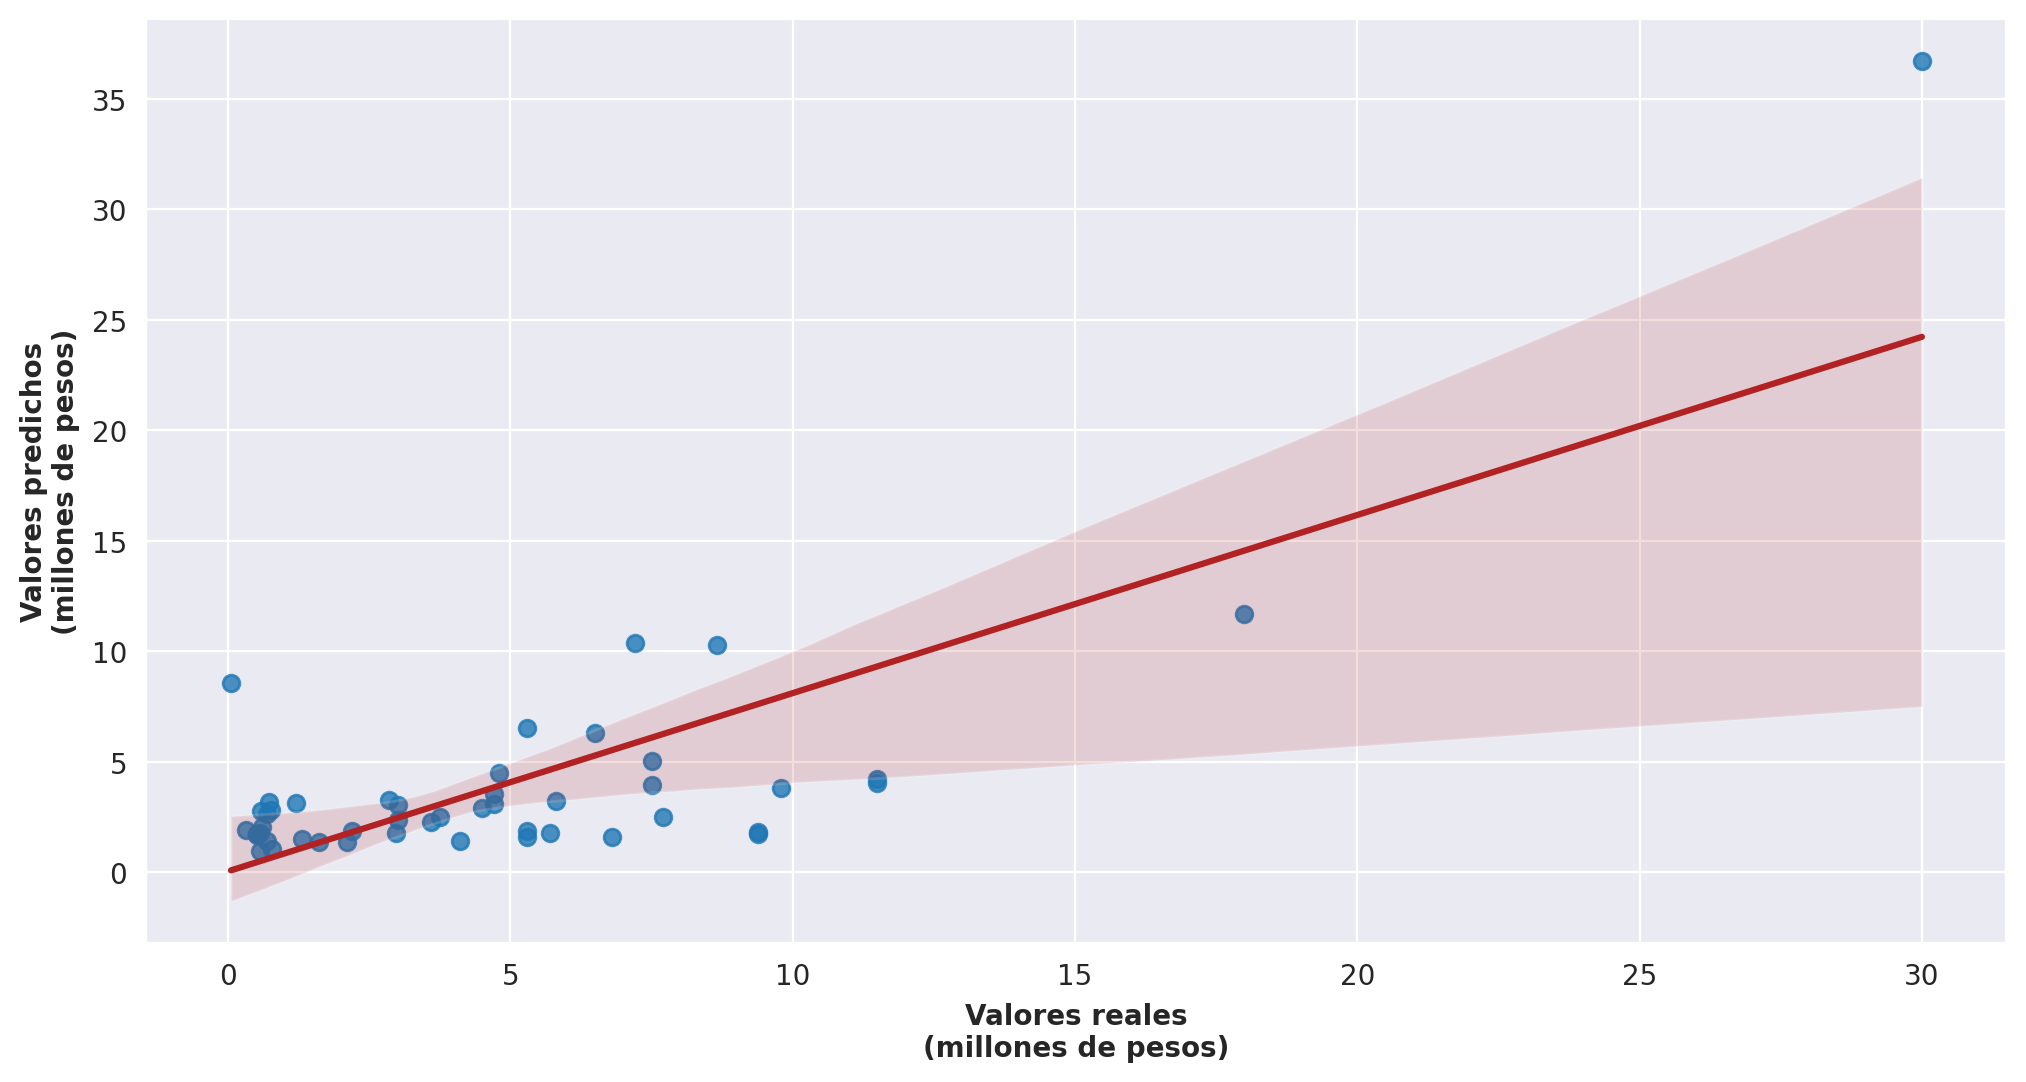

In [49]:
# Se muestra la relación entre los valores predichos y los valores reales
ax = sns.regplot(data=linear_model_predictions,
            x=linear_model_predictions.y_real/1000000, 
            y=linear_model_predictions.y_predicha/1000000,
            line_kws={"color": "firebrick"})
ax.set_ylabel("Valores predichos\n(millones de pesos)",
              weight="bold")
ax.set_xlabel("Valores reales\n(millones de pesos)",
              weight="bold")

plt.show()

Al comparar los valores reales y los predichos se puede observar tanto en la tabla como en la gráfica que las estimaciones del modelo son muy pobres

In [157]:
# Se evalua el desempeño del modelo mediante las méricas R2 y MSE
lineal_metrics = pd.DataFrame({"R2": r2_score(y_true=np.exp(y_test_log), y_pred=np.exp(linear_predict)).round(3),
              "RMSE": mean_squared_error(y_true=np.exp(y_test_log), 
                                       y_pred=np.exp(linear_predict),
                                       squared=False).round(3)},
             index=["Reg_linear"])

lineal_metrics

,R2,RMSE
Reg_linear,0.547,3514754.589


## Regresión Lasso

In [51]:
# Se entrena un modelo de regresión con penalizaciones sobre los coeficientes
lasso_pipe = preprocesamiento_datos_creacion_pipeline(LassoCV(
    alphas=np.logspace(-10, 1, 20),
    cv=5)
).fit(X=X_train_log, y=y_train_log.ravel())

In [52]:
# Se guarda el modelo entrenado en una variable
lasso_model = lasso_pipe.named_steps["model"]

In [53]:
lasso_alpha = lasso_model.alpha_
print(f"El mejor valor de alpha encontrado es: {np.round(lasso_alpha, 5)}")

El mejor valor de alpha encontrado es: 0.01274


In [54]:
# Se muestran los valores de los estimadores
print(f"intersección: {lasso_model.intercept_.round(2)}")
for name, coef in zip(lasso_model.feature_names_in_, lasso_model.coef_.flatten()):
    print(f"{name}: {coef.round(4)}")

intersección: 14.56
numeric__bedrooms: 0.1488
numeric__bathrooms: 0.2395
numeric__built_area: -0.0555
numeric__land_area: 0.4183
categorical__location_nw: 0.5721
categorical__location_se: 0.0
categorical__location_sw: -0.0


In [170]:
# Valores observados vs predichos
lasso_predict = lasso_pipe.predict(X_test_log)
lasso_model_predictions = pd.DataFrame(
    {
    "y_real": np.exp(y_test_log.flatten()).round(3),
    "y_predicha": np.exp(lasso_predict.flatten()).round(0)
    }
)

lasso_model_predictions.head(10)

,y_real,y_predicha
0,11500000.0,4327833.0
1,5700000.0,1834385.0
2,5300000.0,6098868.0
3,568000.0,1002334.0
4,7700000.0,2542643.0
5,6800000.0,1776986.0
6,1210000.0,3132531.0
7,9380000.0,1805972.0
8,7500000.0,5003006.0
9,3000000.0,2533831.0


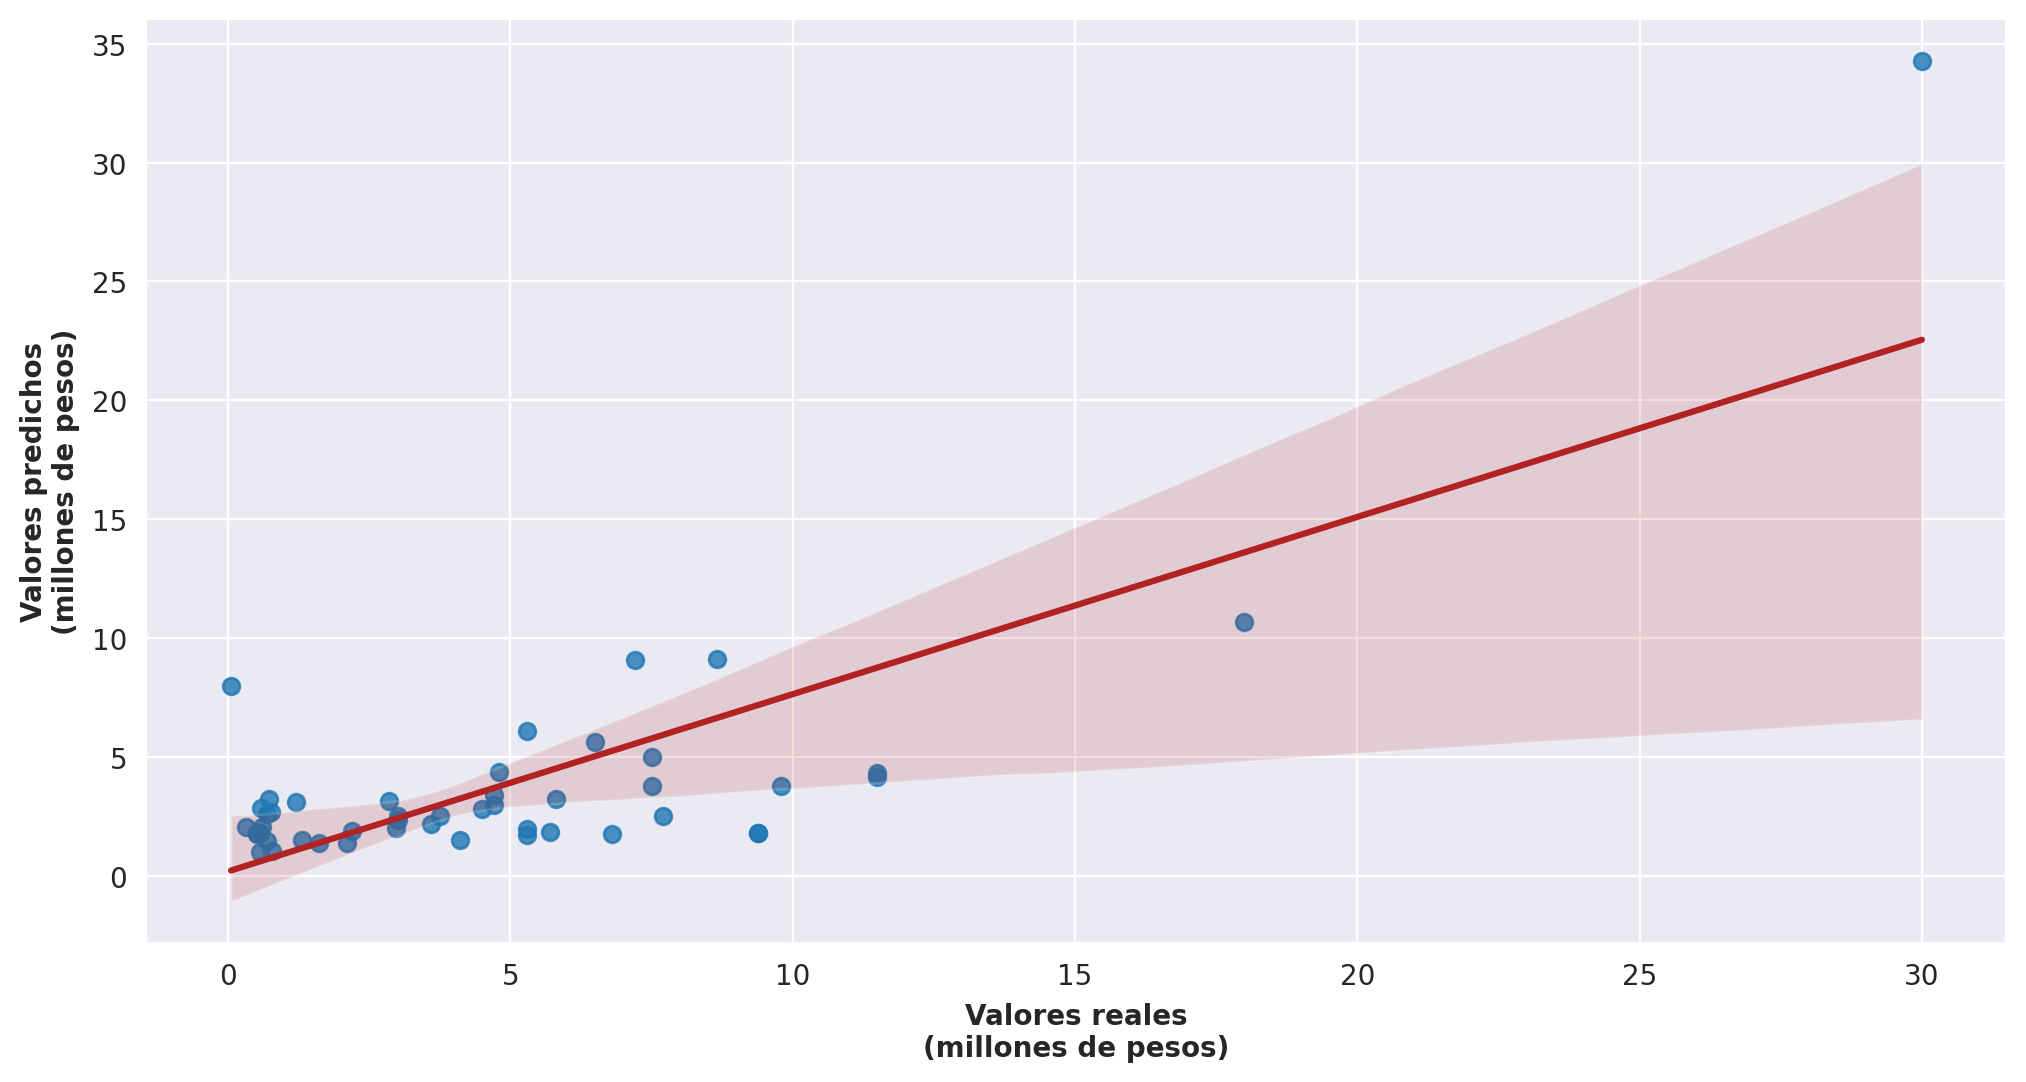

In [56]:
# Se muestra la relación entre los valores predichos y los valores reales
ax = sns.regplot(data=lasso_model_predictions,
            x=lasso_model_predictions.y_real/1000000, 
            y=lasso_model_predictions.y_predicha/1000000,
            line_kws={"color": "firebrick"})
ax.set_ylabel("Valores predichos\n(millones de pesos)",
              weight="bold")
ax.set_xlabel("Valores reales\n(millones de pesos)",
              weight="bold")

plt.show()

In [156]:
lasso_metrics = pd.DataFrame({"R2": r2_score(y_true=np.exp(y_test_log), y_pred=np.exp(lasso_predict)).round(3),
              "RMSE": mean_squared_error(y_true=np.exp(y_test_log), 
                                       y_pred=np.exp(lasso_predict),
                                       squared=False).round(3)},
             index=["Lasso"])

lasso_metrics

,R2,RMSE
Lasso,0.575,3407095.074


Aunque el modelo con penalizaciones mejora respecto al anterior, esta merjoría no es significativa.

De acuerdo con el desempeño observado por los modelos se puede ver que la relación entre las variables predictoras y la variable respuesta no es lineal

Esta será la referencia sobre la que se compararán otros modelos para medir su precisión

## Regresión Polinomial

In [58]:
cat_cols = X_train.select_dtypes(include=["object"]).columns.to_list()
num_cols = X_train.select_dtypes(include=["float", "int"]).columns.to_list()

# Tranformar las variables numéricas
numeric_transformer = Pipeline(
                        steps=[
                            ("scaler", StandardScaler())
                        ]
                    )

# Transformación de variables categóricas
categorical_transformer = Pipeline(
                            steps=[
                                ("onehot", OneHotEncoder(handle_unknown="ignore",
                                                            sparse_output=False, 
                                                            drop="first"))
                            ]
                        )

# Se transforman los datos para entrenar el modelo
preprocessor = ColumnTransformer(
                transformers=[
                    ("numeric", numeric_transformer, num_cols),
                    ("categorical", categorical_transformer, cat_cols)
                ],
                remainder="passthrough"
            ).set_output(transform="pandas")

In [59]:
data_procesada = preprocessor.fit_transform(X_train_log)

In [60]:
# Creo un pipeline con un modelo tipo Lasso al que se le agregaran caracteristicas polinomiales
poli_pipe = make_pipeline(PolynomialFeatures(2),
                          LassoCV(alphas=np.logspace(-10, 1, 20),
                                  cv=RepeatedKFold(n_splits=5, n_repeats=5),
                                  max_iter=100000))

# Se austa el modelo con los datos de entrenamiento
_ = poli_pipe.fit(data_procesada, y_train_log.reshape(-1))

In [61]:
poli_features = poli_pipe.named_steps["polynomialfeatures"]
poli_model = poli_pipe.named_steps["lassocv"]
# Accediendo a los nombres de las variables generadas por el modelo
poli_var_names = poli_features.get_feature_names_out(
    input_features=poli_pipe.feature_names_in_)

print(f"Variables del modelo: {sum(poli_model.coef_ != 0)}")
print("=========================================\n")
# print(f"Variables distintas a cero")
print(f"Intercección: {poli_model.intercept_}")
for name, value in zip(poli_var_names, poli_model.coef_):
    if value != 0:
        print(f"{name}: {value}")

Variables del modelo: 9

Intercección: 14.518073546927601
numeric__bedrooms: 0.12670282927972956
numeric__bathrooms: 0.12580048692238704
numeric__land_area: 0.32672754358985745
categorical__location_nw: 0.4680527783663506
numeric__bedrooms numeric__bathrooms: -0.01916730420472396
numeric__bathrooms^2: 0.07974979291710595
numeric__bathrooms numeric__land_area: -0.07590793237179061
numeric__built_area^2: 0.03987712239396886
categorical__location_nw^2: 0.03566565210293614


In [62]:
print(f"Valor óptimo de alpha {poli_model.alpha_}")

Valor óptimo de alpha 0.04832930238571752


In [168]:
poli_predict = poli_pipe.predict(preprocessor.transform(X_test_log))
poli_model_predictions = pd.DataFrame({
    "y_real": np.exp(y_test_log.flatten()).round(0),
    "y_predicha": np.exp(poli_predict).round(0)
})

poli_model_predictions.head(10)

,y_real,y_predicha
0,11500000.0,4440653.0
1,5700000.0,1804486.0
2,5300000.0,6431405.0
3,568000.0,1197666.0
4,7700000.0,2564455.0
5,6800000.0,1802258.0
6,1210000.0,3129720.0
7,9380000.0,1785105.0
8,7500000.0,4508648.0
9,3000000.0,2410563.0


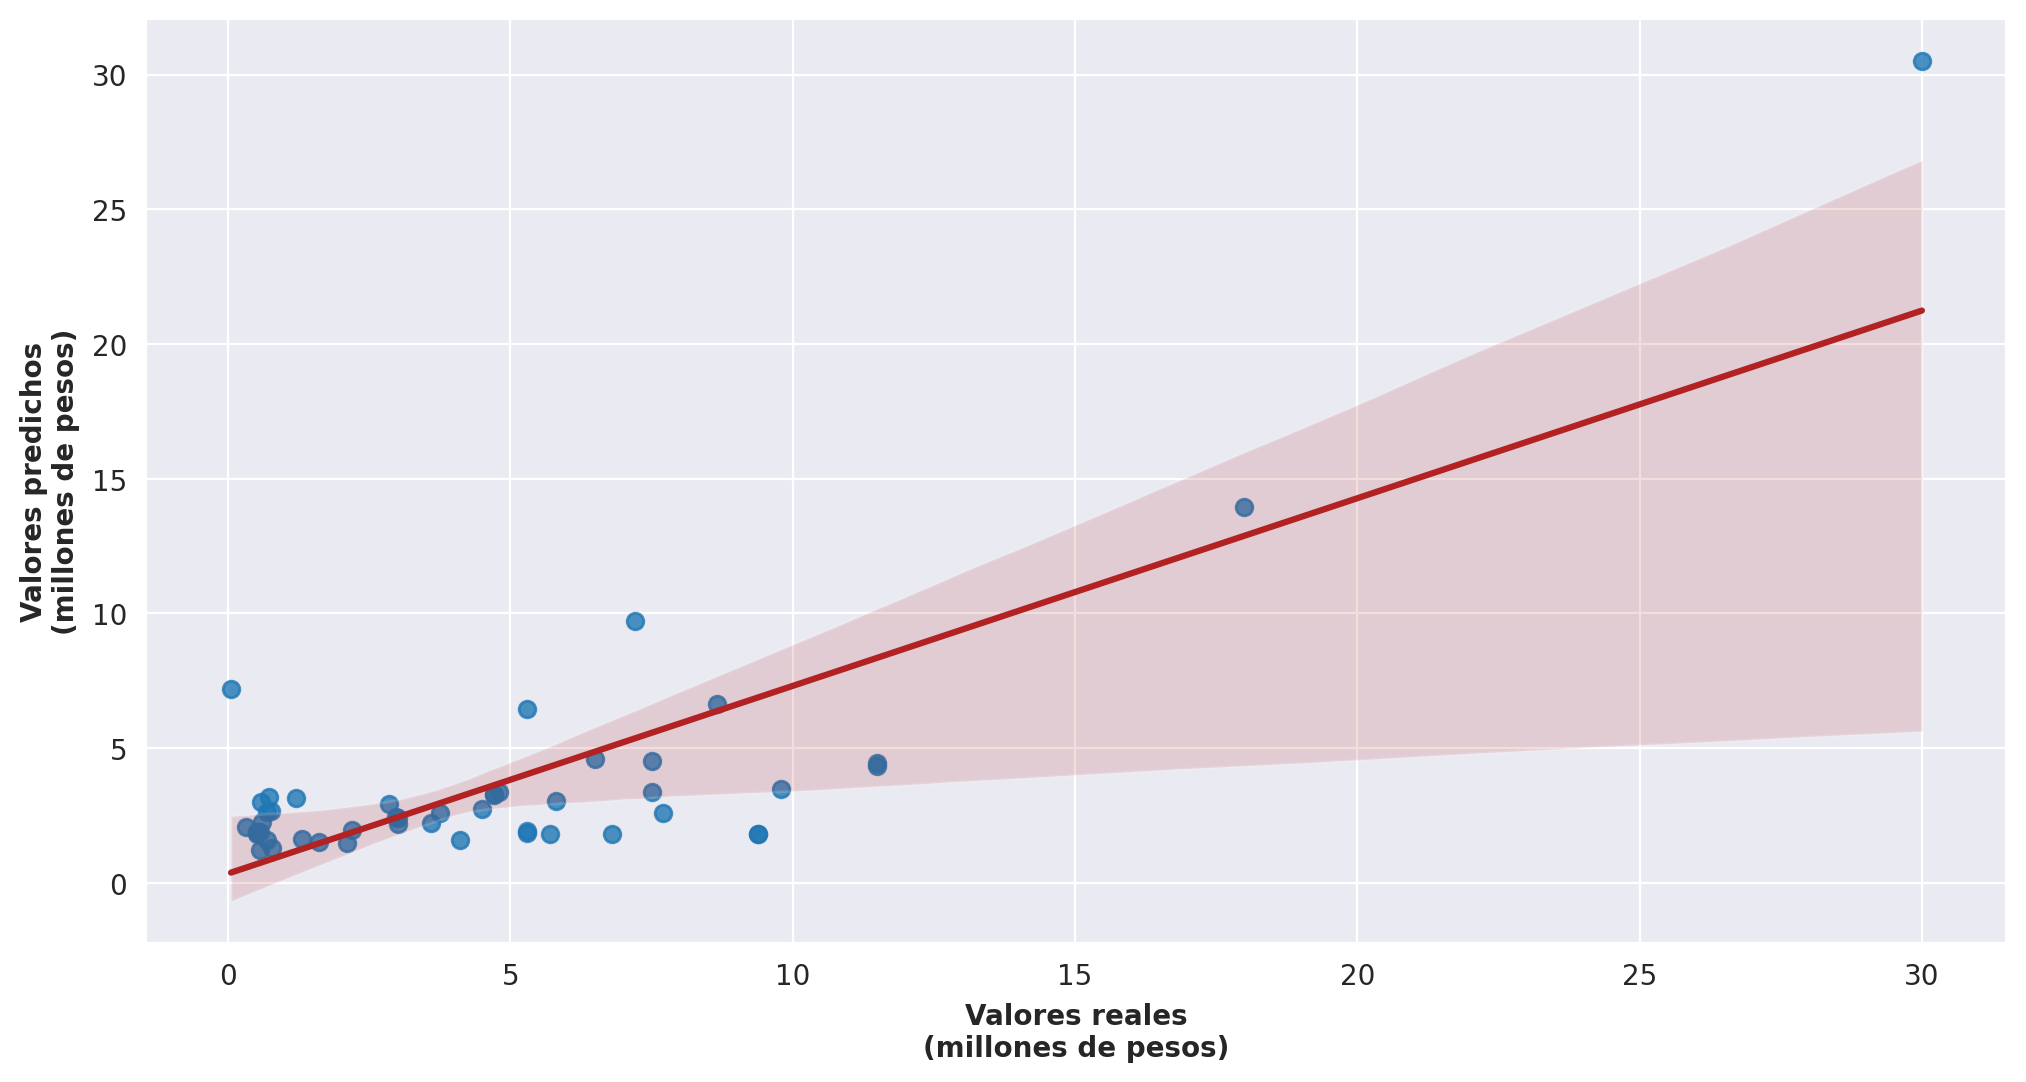

In [64]:
# Se muestra la relación entre los valores predichos y los valores reales
ax = sns.regplot(data=poli_model_predictions,
            x=poli_model_predictions.y_real/1000000, 
            y=poli_model_predictions.y_predicha/1000000,
            line_kws={"color": "firebrick"})
ax.set_ylabel("Valores predichos\n(millones de pesos)",
              weight="bold")
ax.set_xlabel("Valores reales\n(millones de pesos)",
              weight="bold")

plt.show()

In [155]:
poli_metrics = pd.DataFrame({"R2": r2_score(y_true=np.exp(y_test_log), y_pred=np.exp(poli_predict)).round(3),
              "RMSE": mean_squared_error(y_true=np.exp(y_test_log), 
                                       y_pred=np.exp(poli_predict),
                                       squared=False).round(3)},
             index=["Polinomial"])

poli_metrics

,R2,RMSE
Polinomial,0.611,3259665.787


Como se esperaba, al hacer más flexible el modelo se logró un mejor ajuste pero el aumento fue pequeño, así que será mejor intentar con modelos que más flexibles.

## K-Nearest Neighbor

In [161]:
# Se crea un pipeline con los datos transformados para el modelo K-NN
knn_pipe = preprocesamiento_datos_creacion_pipeline(KNeighborsRegressor())

# Se establece el espacio de búsqueda de los hiperparámetros
param_distributions = {"model__n_neighbors": np.linspace(1, 100, 500, dtype=int)}

# Se hace la búsqueda del mejor hiperparámetro
knn_grid = RandomizedSearchCV(
    estimator=knn_pipe,
    param_distributions=param_distributions,
    n_iter=10,
    scoring="neg_root_mean_squared_error",
    cv=RepeatedKFold(n_splits=5, n_repeats=3),
    refit=True,
    verbose=0,
    random_state=123,
    return_train_score=False
)

_ = knn_grid.fit(X=X_train, y=y_train)


In [162]:
# El valor óptimo del hiperparámetro n_neighbors es 26 
resultados = pd.DataFrame(knn_grid.cv_results_).sort_values(by="rank_test_score")
resultados.loc[:, ["param_model__n_neighbors", "mean_test_score", 
                   "std_test_score", "rank_test_score"]].head(1)

,param_model__n_neighbors,mean_test_score,std_test_score,rank_test_score
5,26,-5.308364e+06,2.415008e+06,1


In [167]:
knn_model = knn_grid.best_estimator_
knn_predict = knn_model.predict(X_test)
knn_model_predictions = pd.DataFrame({
    "y_real": y_test.flatten().round(1),
    "y_predicha": knn_predict.flatten().round(1)
})
knn_model_predictions.head(10)

,y_real,y_predicha
0,11500000.0,6479479.9
1,5700000.0,2601092.3
2,5300000.0,6955769.2
3,568000.0,1942581.0
4,7700000.0,3323990.0
5,6800000.0,1839026.9
6,1210000.0,3411249.2
7,9380000.0,2552874.2
8,7500000.0,5834864.5
9,3000000.0,2351284.6


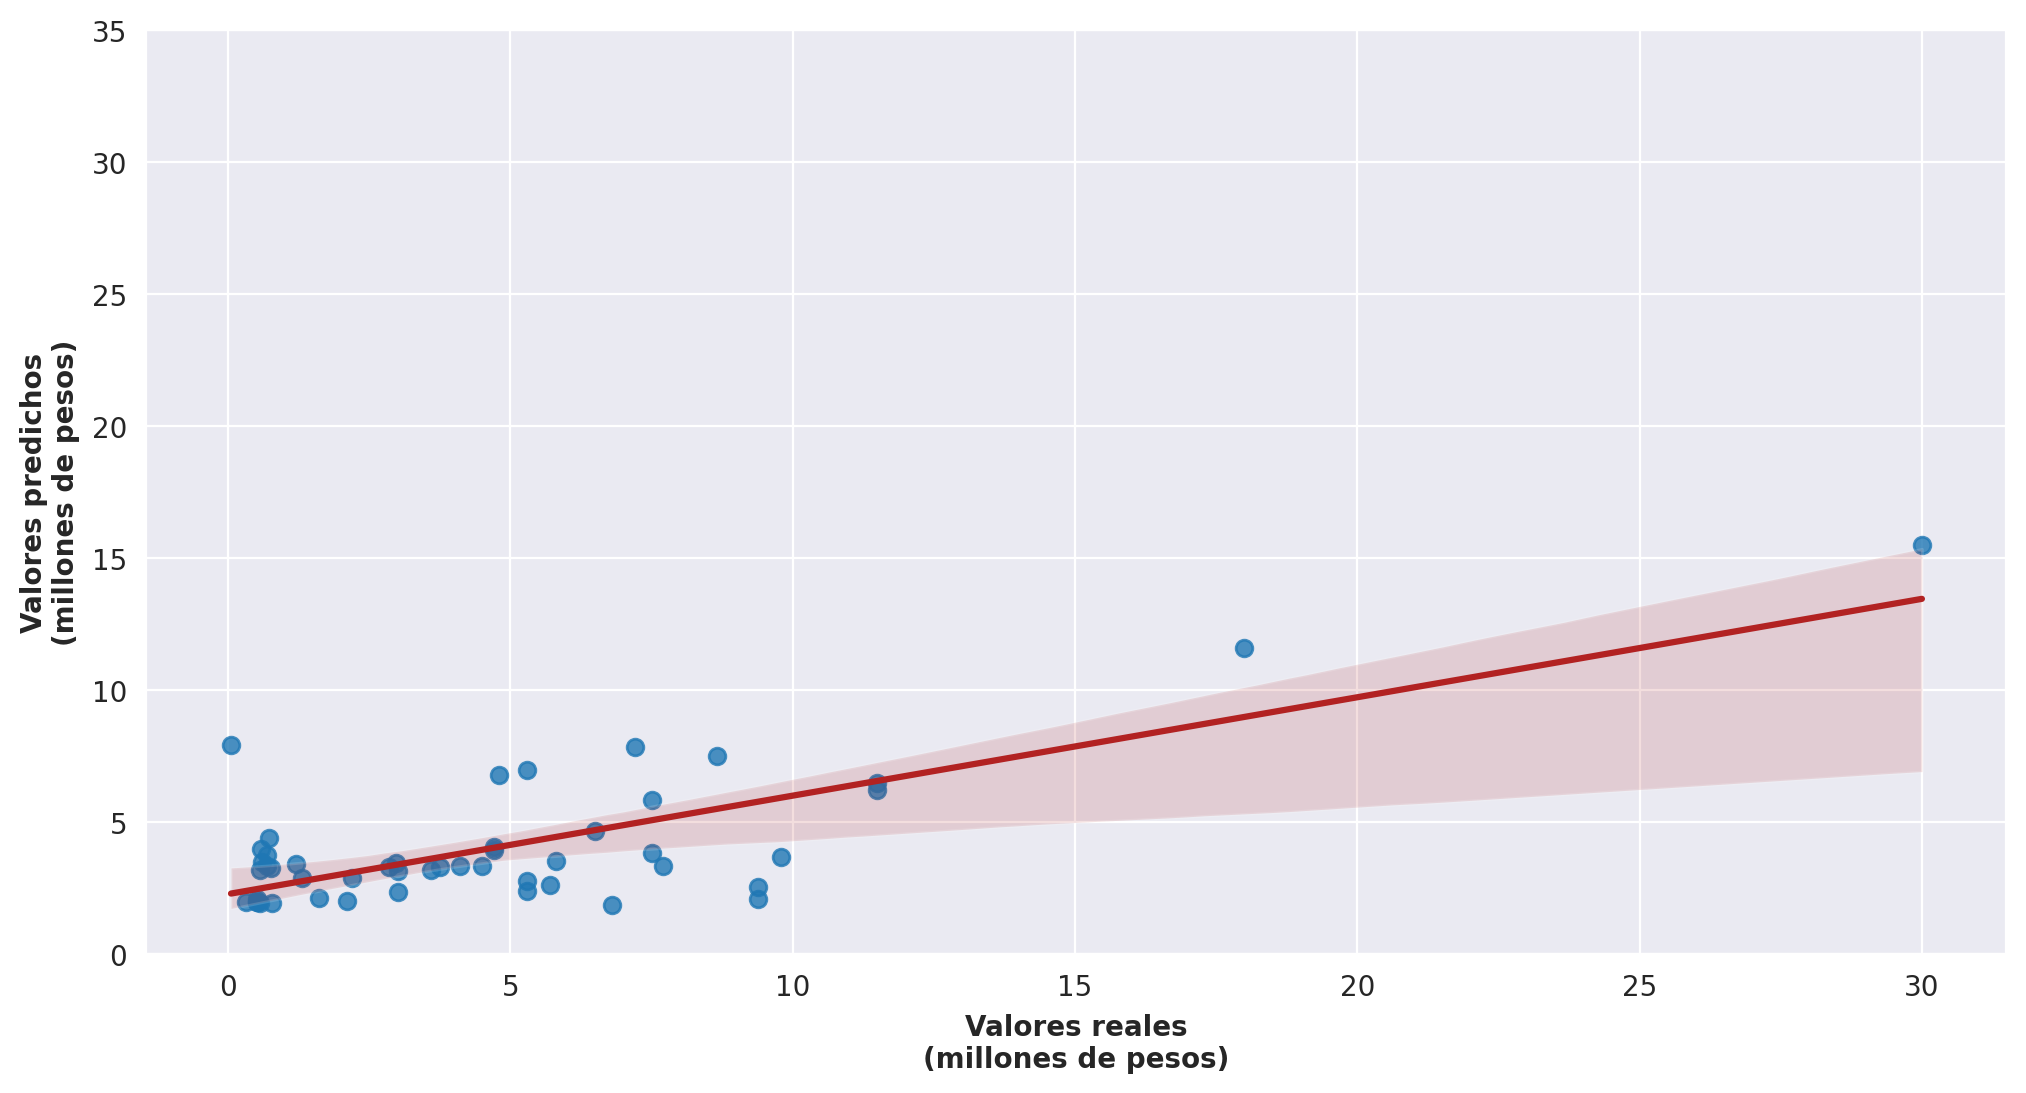

In [164]:
# Se muestra la relación entre los valores predichos y los valores reales
ax = sns.regplot(data=knn_model_predictions,
            x=knn_model_predictions.y_real/1000000, 
            y=knn_model_predictions.y_predicha/1000000,
            line_kws={"color": "firebrick"})
ax.set_ylabel("Valores predichos\n(millones de pesos)",
              weight="bold")
ax.set_xlabel("Valores reales\n(millones de pesos)",
              weight="bold")
ax.set_ylim(0, 35)

plt.show()

In [165]:
knn_metrics = pd.DataFrame({"R2": r2_score(y_true=y_test, y_pred=knn_predict).round(3),
              "RMSE": mean_squared_error(y_true=y_test, 
                                       y_pred=knn_predict,
                                       squared=False).round(3)},
             index=["K-NN"])

knn_metrics

,R2,RMSE
K-NN,0.482,3760584.913


In [166]:
pd.concat([lineal_metrics, lasso_metrics, poli_metrics, knn_metrics], axis=0).sort_values(by="R2", ascending=False)

,R2,RMSE
Polinomial,0.611,3259665.787
Lasso,0.575,3407095.074
Reg_linear,0.547,3514754.589
K-NN,0.482,3760584.913
